# Transit Fitting

Welcome to the transit fitting tutorial of `chromatic_fitting`! In this tutorial we will go through how to create a simulated transit using the handy `chromatic` package and then fit it using the transit model (`TransitModel`) in `chromatic_fitting`.

In [1]:
# import chromatic_fitting of course!
from chromatic_fitting import *

# import any prior distributions we want to use for our parameters - I've chosen Normal and Uniform from pymc3
# and QuadLimbDark and ImpactParameter from exoplanet
from pymc3 import Normal, Uniform
from exoplanet import QuadLimbDark, ImpactParameter

# import astropy table just for this tutorial (pandas dataframes don't show up nicely on the docs pages!)
from astropy.table import Table
import matplotlib.pyplot as plt 

plt.matplotlib.style.use('default')

Running chromatic_fitting v0.11.0!

This program is running on:
Python v3.9.12 (main, Jun  1 2022, 06:34:44) 
[Clang 12.0.0 ]
numpy v1.22.1
chromatic v0.4.5
pymc3 v3.11.5
pymc3_ext v0.1.1
exoplanet v0.5.2


## Create Synthetic Rainbow + Transit

To create our simulated data set we will use `SimulatedRainbow()` from within `chromatic`. This creates only basic data with time and wavelength axes. Then we want to inject some noise (to make it realistic) and then inject a transit (the whole point of this tutorial). By default `chromatic` will inject a planet with Rp/R* of 0.1, but we want to make things a little more realistic so we will make the radius ratio vary linearly with wavelength.

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

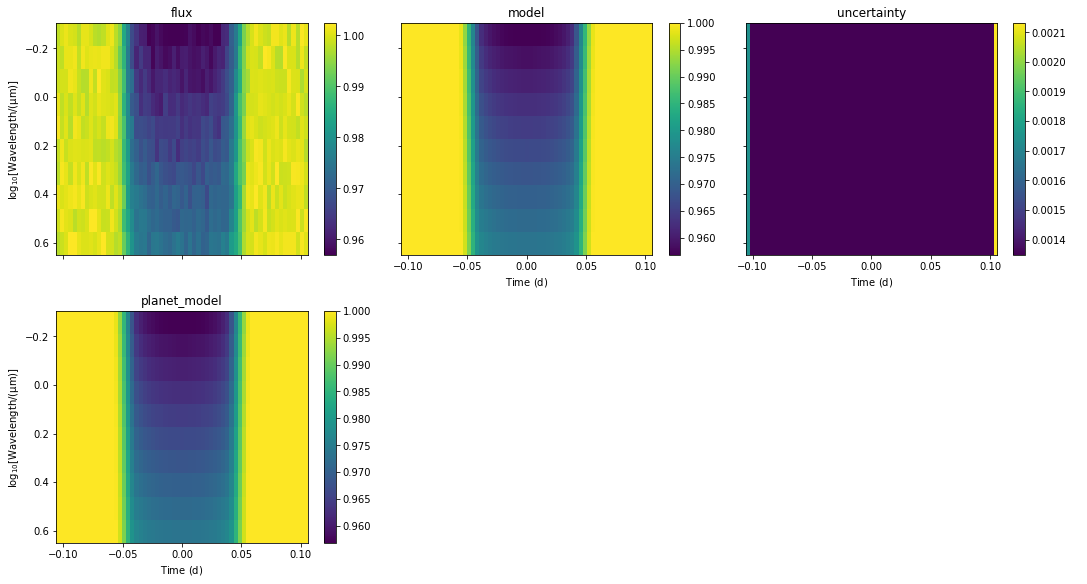

In [2]:
# create transit rainbow:
r = SimulatedRainbow(dt=1 * u.minute, R=50).inject_noise(signal_to_noise=100)

# add transit (with depth varying with wavelength):
r = r.inject_transit(
        planet_radius=np.linspace(0.2, 0.15, r.nwave),
        P=1.0,
        t0=0.0,
        baseline=1.0
    )

# bin into 10 wavelength bins:
nw = 10
rb = r.bin(nwavelengths=int(r.nwave/nw), dt=5 * u.minute)

# show the simulated dataset
rb.imshow_quantities();

In [3]:
rb

<Simulated🌈(10w, 61t)>

## Define a PyMC3 Transit Model

Now onto `chromatic_fitting`. First we need to create a transit model.

In [4]:
# create transit model:
t = TransitModel()

Then we will want to decide how our parameters will vary. We can see the parameters that we will need to provide to the model. **Warning:** if we dont set any of these parameters then they will take on default values.

In [5]:
t.required_parameters

['stellar_radius',
 'stellar_mass',
 'radius_ratio',
 'period',
 'epoch',
 'baseline',
 'impact_parameter',
 'limb_darkening']

In [6]:
t.defaults

{'stellar_radius': 1.0,
 'stellar_mass': 1.0,
 'radius_ratio': 1.0,
 'period': 1.0,
 'epoch': 0.0,
 'baseline': 1.0,
 'impact_parameter': 0.5,
 'eccentricity': 0.0,
 'omega': 0,
 'limb_darkening': [0.2, 0.2]}

Usually when we're fitting a transit we'll have some idea about the transit parameters (from previous literature or just looking at the lightcurves by eye), so it's a good idea to give good initial estimates to help our sampling converge nicely. Here we're defining the prior distributions for each parameter. There are four options for parameters in `chromatic_fitting`: `Fixed`, `WavelikeFixed`, `Fitted`, and `WavelikeFitted`. `Fixed` is one value fixed across all wavelengths, `WavelikeFixed` are fixed values that can vary between wavelengths. `Fitted` determines a prior distribution (e.g. `Uniform`, `Normal`, `TruncatedNormal`) that we will use to fit one value for the parameter across all wavelengths. Similarly, `WavelikeFitted` is a prior distribution that we will use to fit for a different value for every wavelength. 

In [7]:
# add our parameters:
t.setup_parameters(
                  period=1.0, # a fixed value!
                   epoch=Fitted(Uniform,lower=-0.05,upper=0.05), # one fitted value across all wavelengths
                   stellar_radius = Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   stellar_mass =Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   radius_ratio=WavelikeFitted(Normal, mu=0.17, sigma=0.05), # a different value fitted for every wavelength!
                   impact_parameter=Fitted(ImpactParameter,ror=0.15,testval=0.44),
                   limb_darkening=WavelikeFitted(Uniform,testval=[0.2,0.2], shape=2),
                    baseline = WavelikeFitted(Normal, mu=1.0, sigma=0.05), 
                )

# print a summary of all params:
t.summarize_parameters()

transit_stellar_radius =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='transit_stellar_radius') 🧮>

transit_stellar_mass =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='transit_stellar_mass') 🧮>

transit_radius_ratio =
  <🧮 WavelikeFitted Normal(mu=0.17, sigma=0.05, name='transit_radius_ratio') for each wavelength 🧮>

transit_period =
  <🧮 Fixed | 1.0 🧮>

transit_epoch =
  <🧮 Fitted Uniform(lower=-0.05, upper=0.05, name='transit_epoch') 🧮>

transit_baseline =
  <🧮 WavelikeFitted Normal(mu=1.0, sigma=0.05, name='transit_baseline') for each wavelength 🧮>

transit_impact_parameter =
  <🧮 Fitted ImpactParameter(ror=0.15, testval=0.44, name='transit_impact_parameter') 🧮>

transit_eccentricity =
  <🧮 Fixed | 0.0 🧮>

transit_omega =
  <🧮 Fixed | 0 🧮>

transit_limb_darkening =
  <🧮 WavelikeFitted Uniform(testval=[0.2, 0.2], shape=2, name='transit_limb_darkening') for each wavelength 🧮>



## Attach the Rainbow Object and Set-up the Model

The next step is to attach the actual data to the model and setup the lightcurves!

In [8]:
# attach the Rainbow object to the model:
t.attach_data(rb)

# this is the last point where we can change the optimization method:
t.choose_optimization_method("separate")

# setup the lightcurves for the transit model & 
# t.setup_lightcurves()
# relate the "actual" data to the model (using a Normal likelihood function)
# t.setup_likelihood()

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:211: UserWarning: transit in the parameter name: transit_stellar_radius. Please avoid having the model name in the parameter name as it can get confusing!
  warnings.warn(


In [9]:
t.setup_lightcurves()

setup_lightcurves called
(<chromatic models (10 separate wavelengths) "transit" 🌈>,)
{}
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromati

Running this once...
plot_orbit called
(<chromatic models (10 separate wavelengths) "transit" 🌈>,)
{}
<class 'chromatic_fitting.models.transit.TransitModel'>


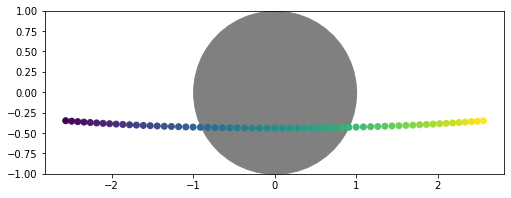

<class 'chromatic_fitting.models.transit.TransitModel'>


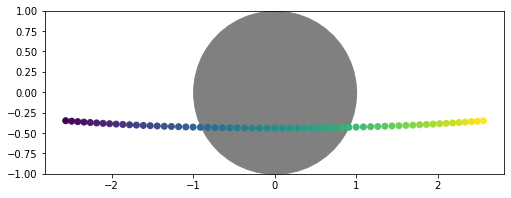

<class 'chromatic_fitting.models.transit.TransitModel'>


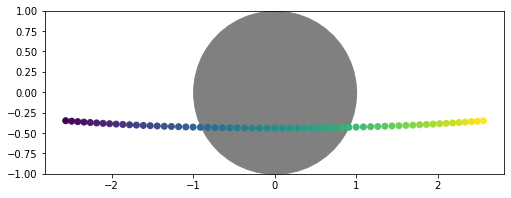

<class 'chromatic_fitting.models.transit.TransitModel'>


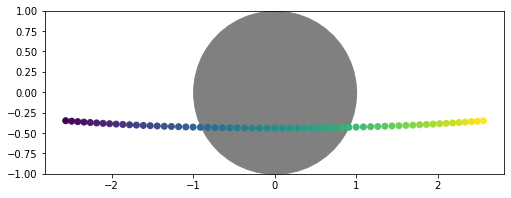

<class 'chromatic_fitting.models.transit.TransitModel'>


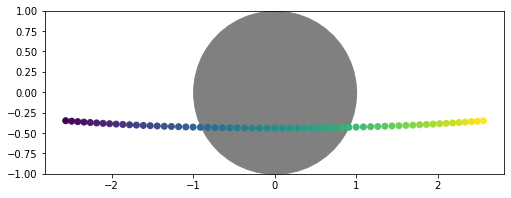

<class 'chromatic_fitting.models.transit.TransitModel'>


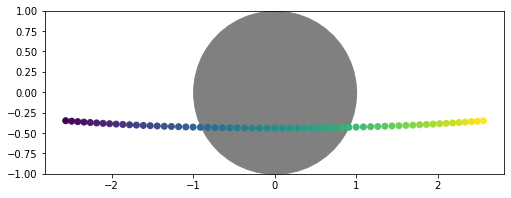

<class 'chromatic_fitting.models.transit.TransitModel'>


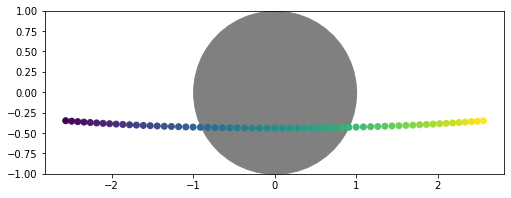

<class 'chromatic_fitting.models.transit.TransitModel'>


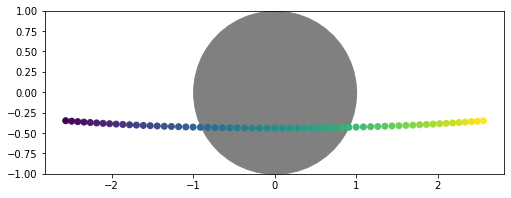

<class 'chromatic_fitting.models.transit.TransitModel'>


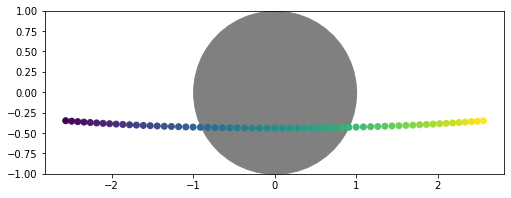

<class 'chromatic_fitting.models.transit.TransitModel'>


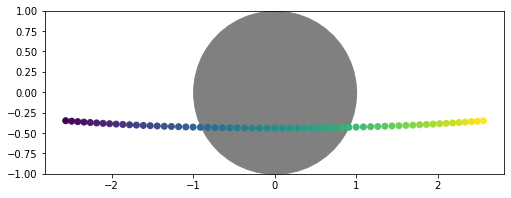

In [10]:
t.plot_orbit()

In [11]:
t.models['w0']._pymc3_model

In [12]:
t.setup_likelihood(mask_outliers=True)

setup_likelihood called
(<chromatic models (10 separate wavelengths) "transit" 🌈>,)
{'mask_outliers': True}
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>


If we look at our `PyMC3` model we can see that it has a lot of parameters to optimize! If we've chosen the separate wavelength fitting method (`.choose_optimization_method("separate")`) then `._pymc3_model` will return a list of PyMC3 models (one for each wavelength).

In [13]:
# print(t._pymc3_model)
t

<chromatic models (10 separate wavelengths) "transit" 🌈>

We've got our transit parameters that are wavelength-independant in this case (`epoch, impact_parameter, stellar_radius, stellar_mass, a_R*, limb_darkening`) and the wavelength-dependant parameters we've defined to be `radius_ratio` and `baseline` only. The `data` parameter just represents the fit of the data to the model at each wavelength (which we've defined to be a Normal distribution). If we've set `store_models = True` at the `.setup_lightcurves()` stage then we will also see a bunch of models!

Now we can plot a couple of priors (samples from our prior distribution) - do they look OK?

plot_priors called
(<chromatic models (10 separate wavelengths) "transit" 🌈>,)
{}
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitt

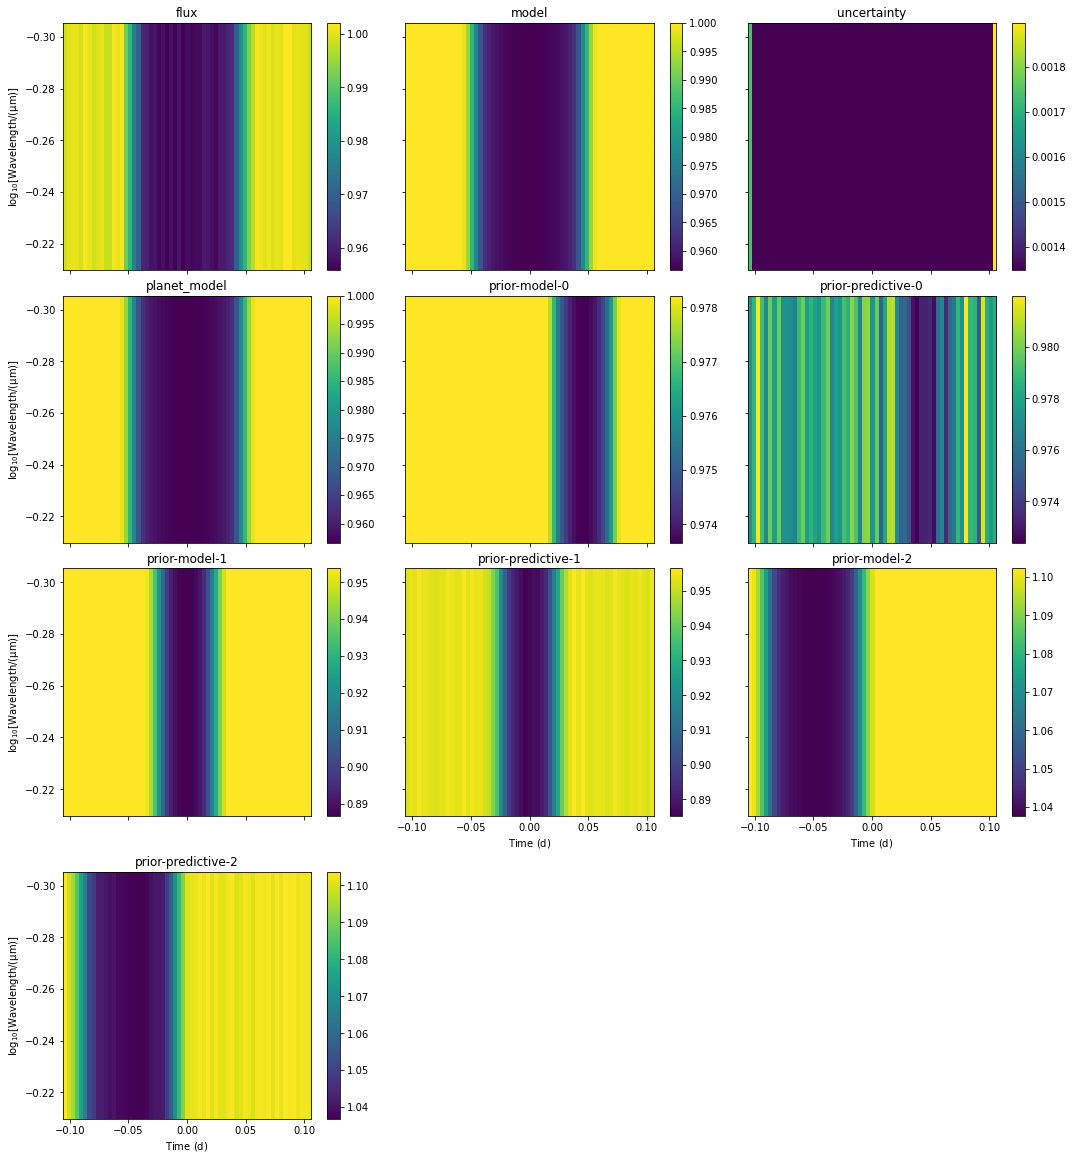

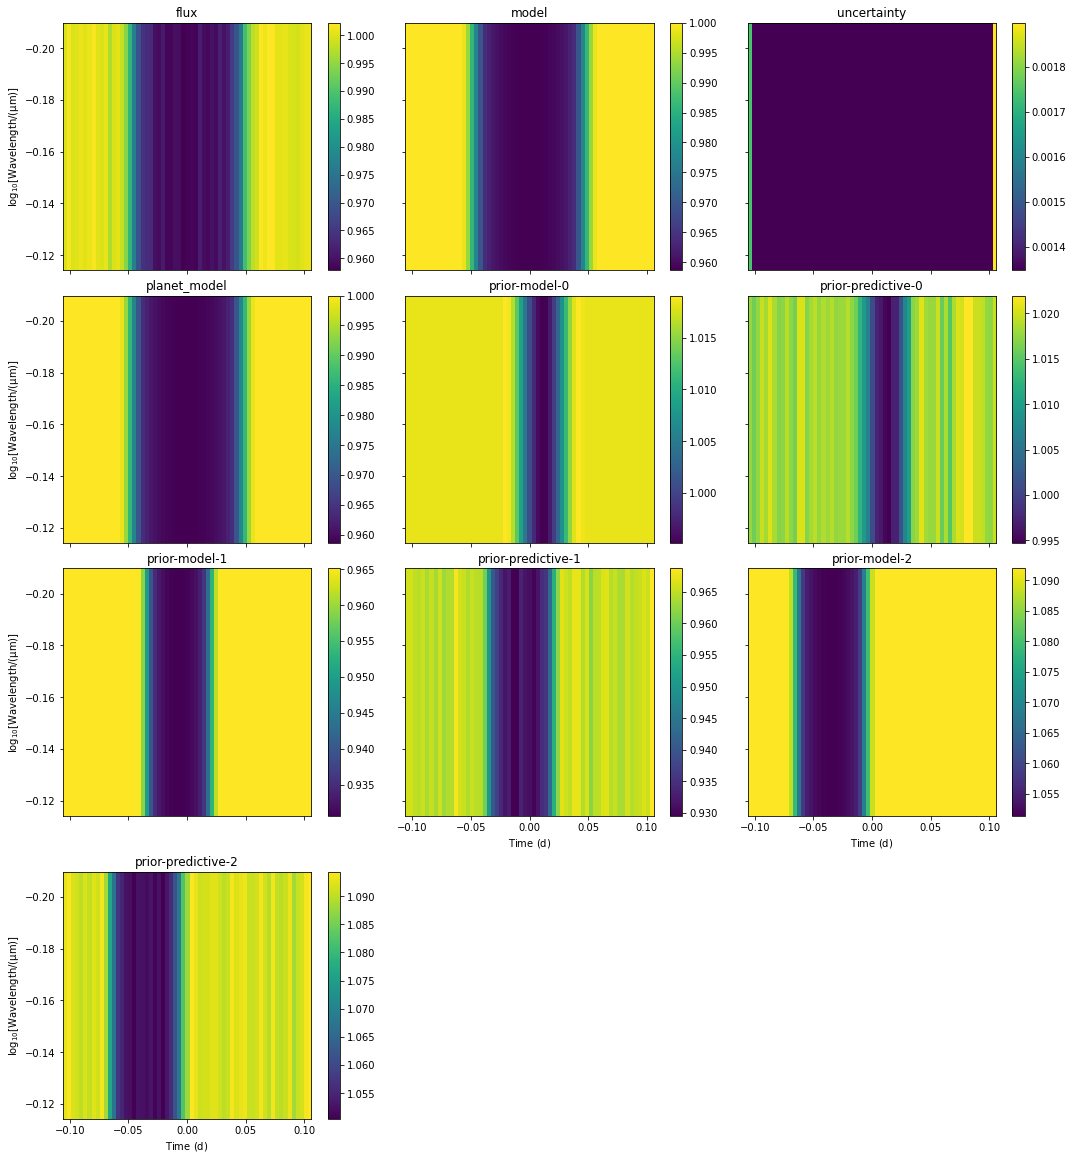

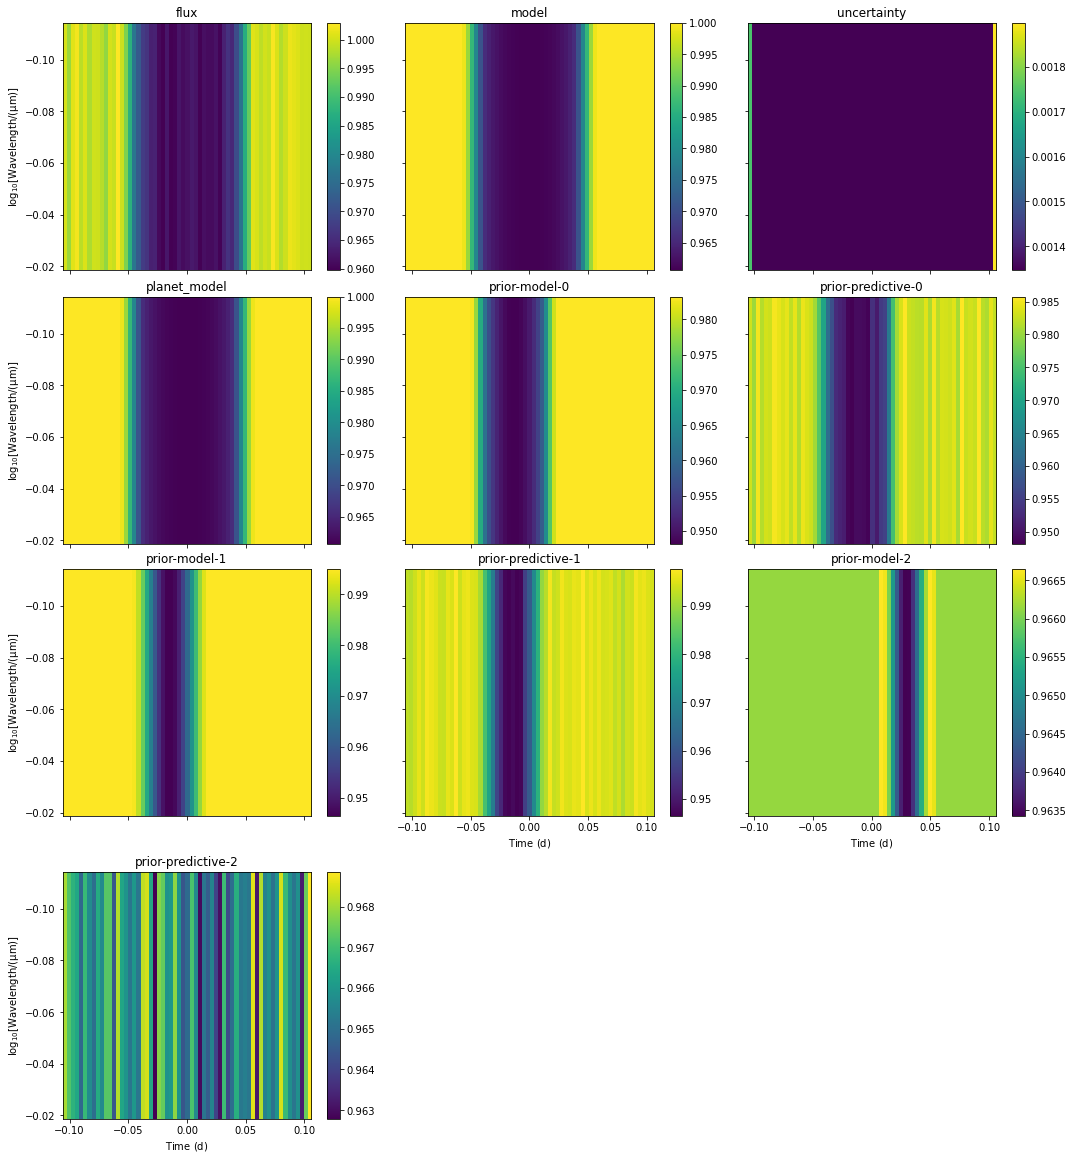

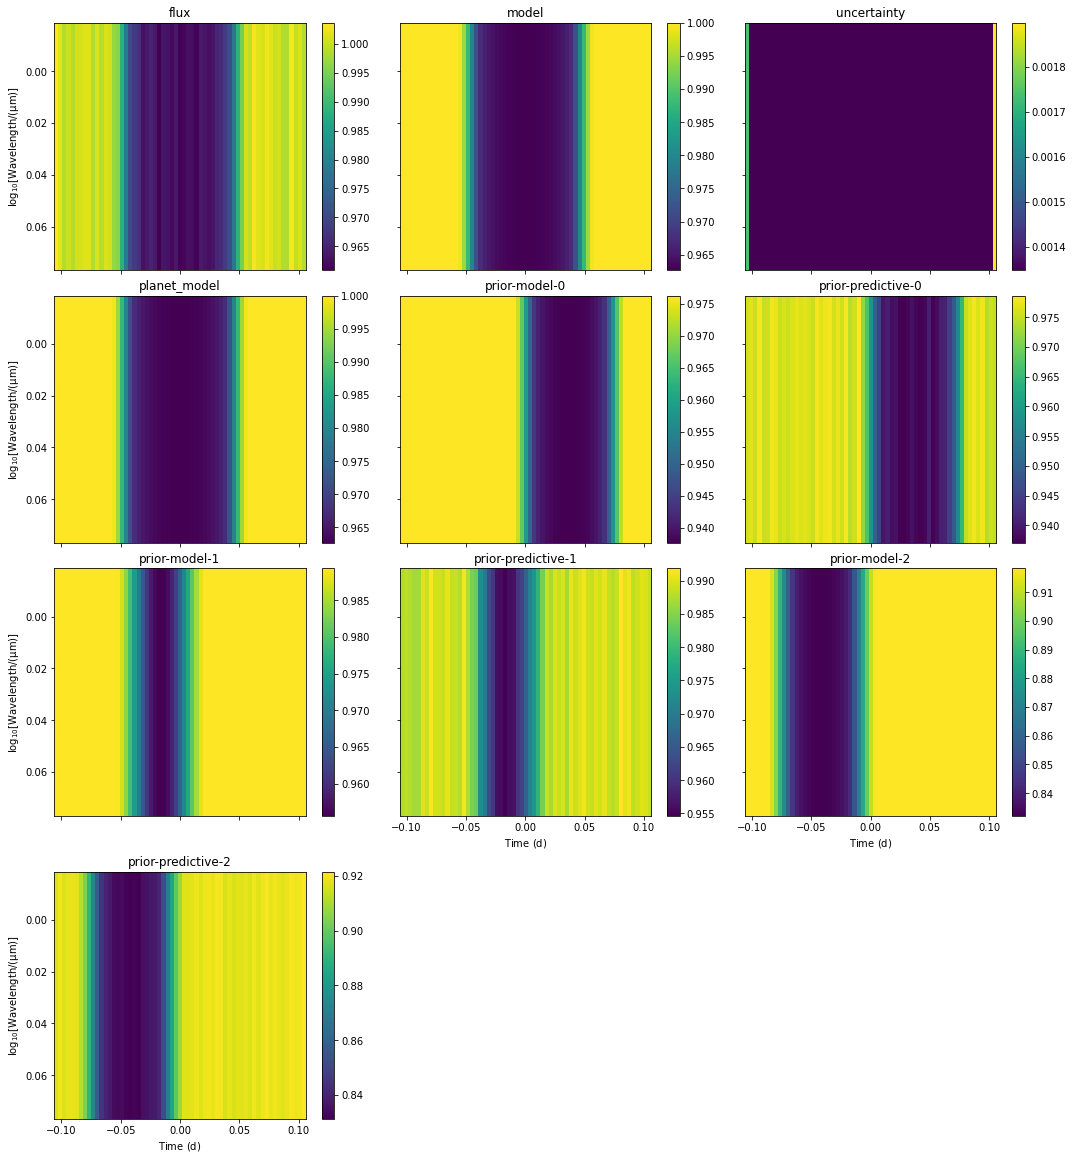

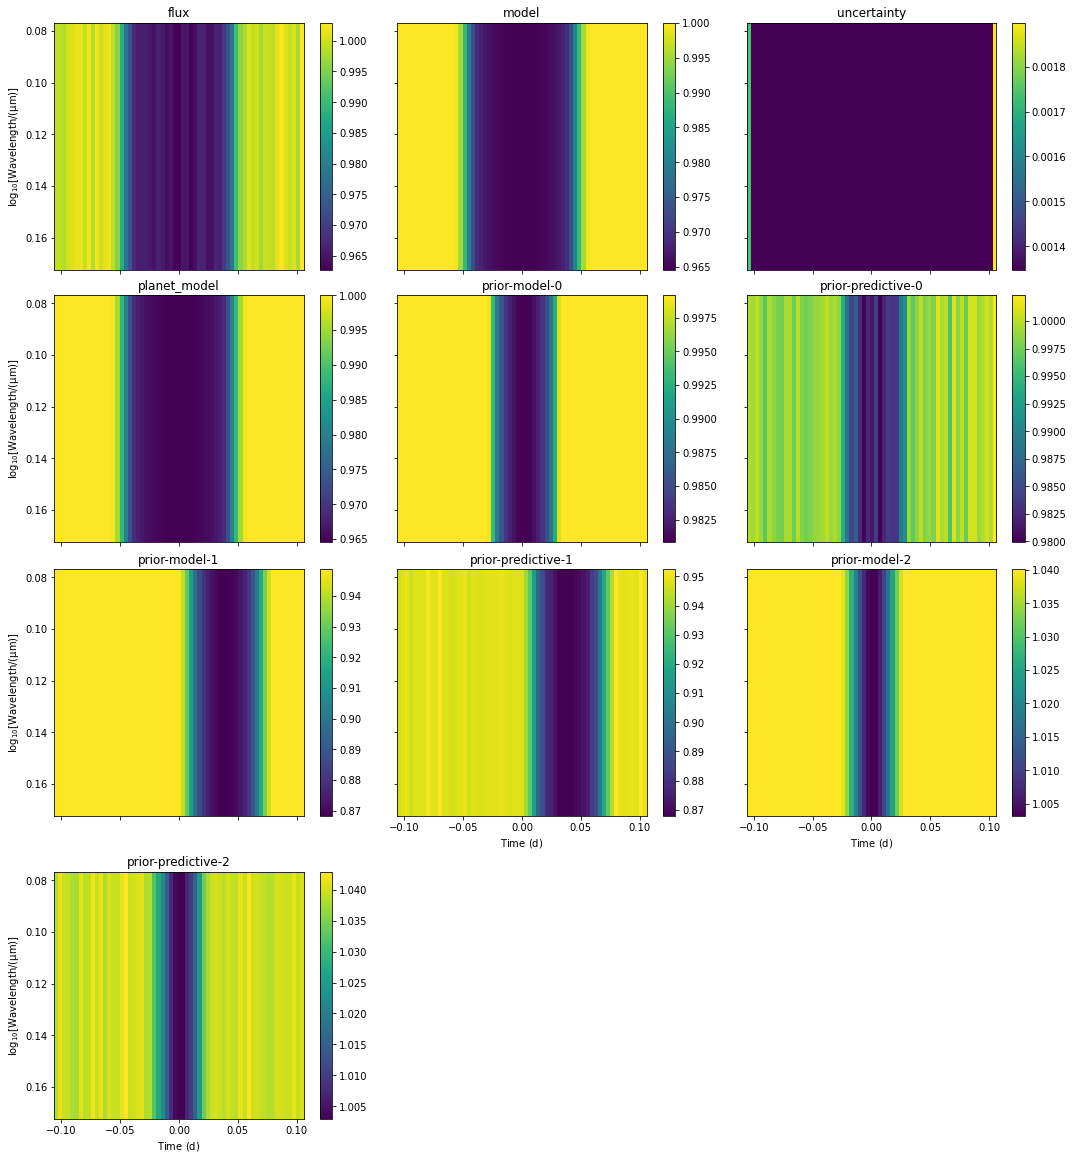

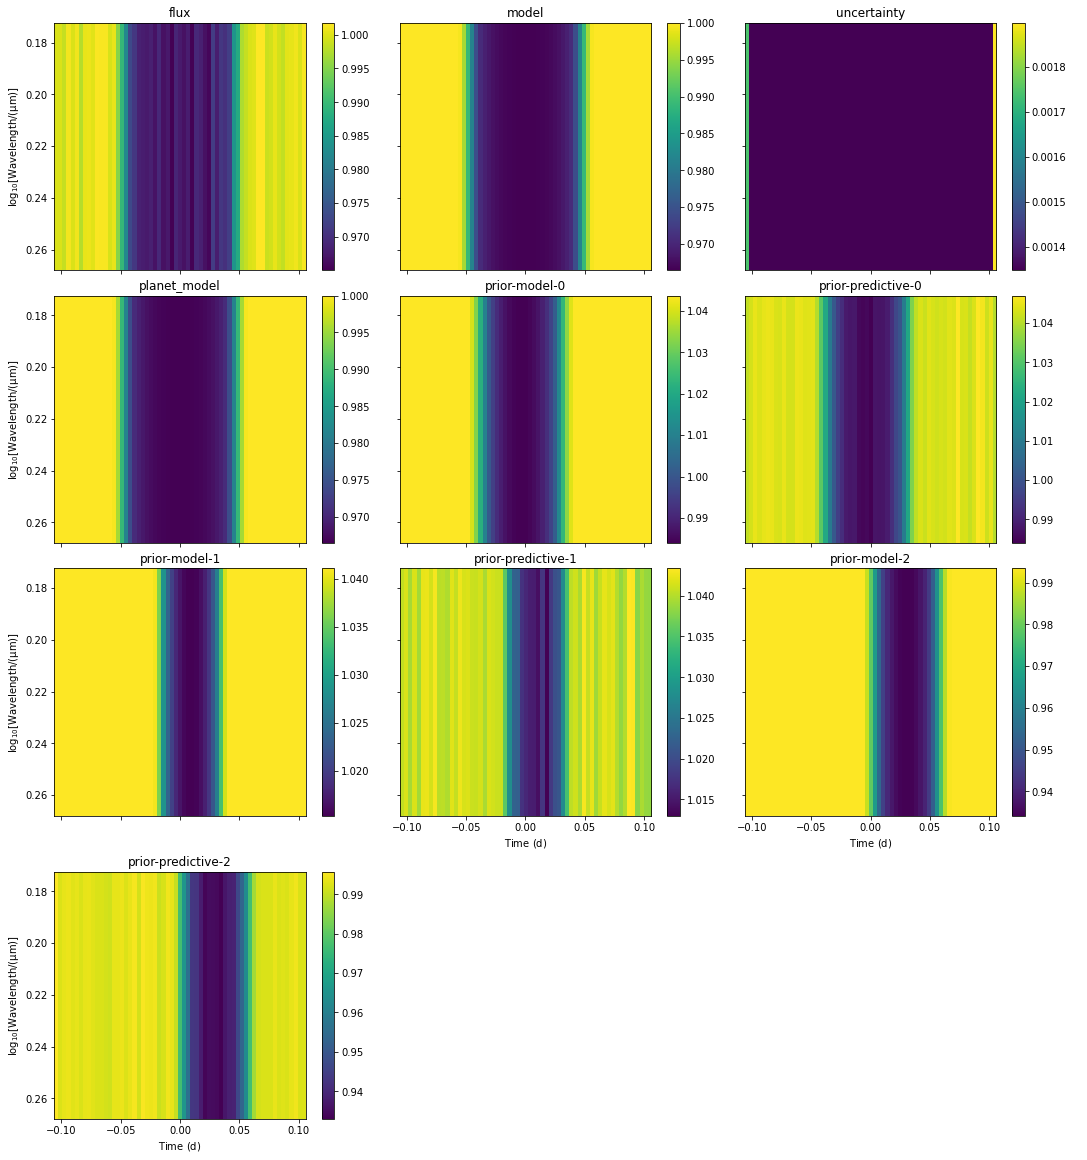

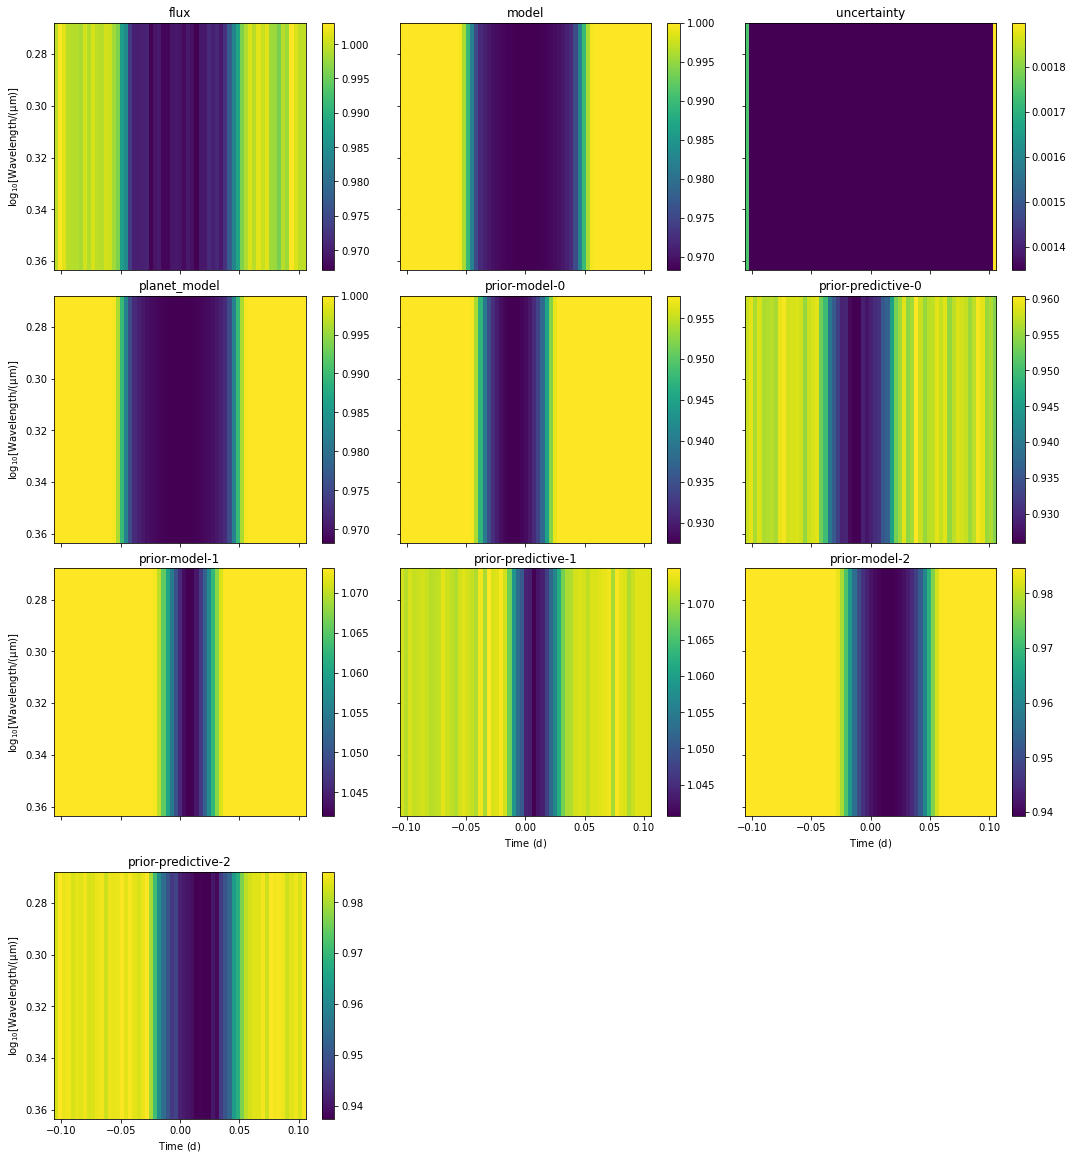

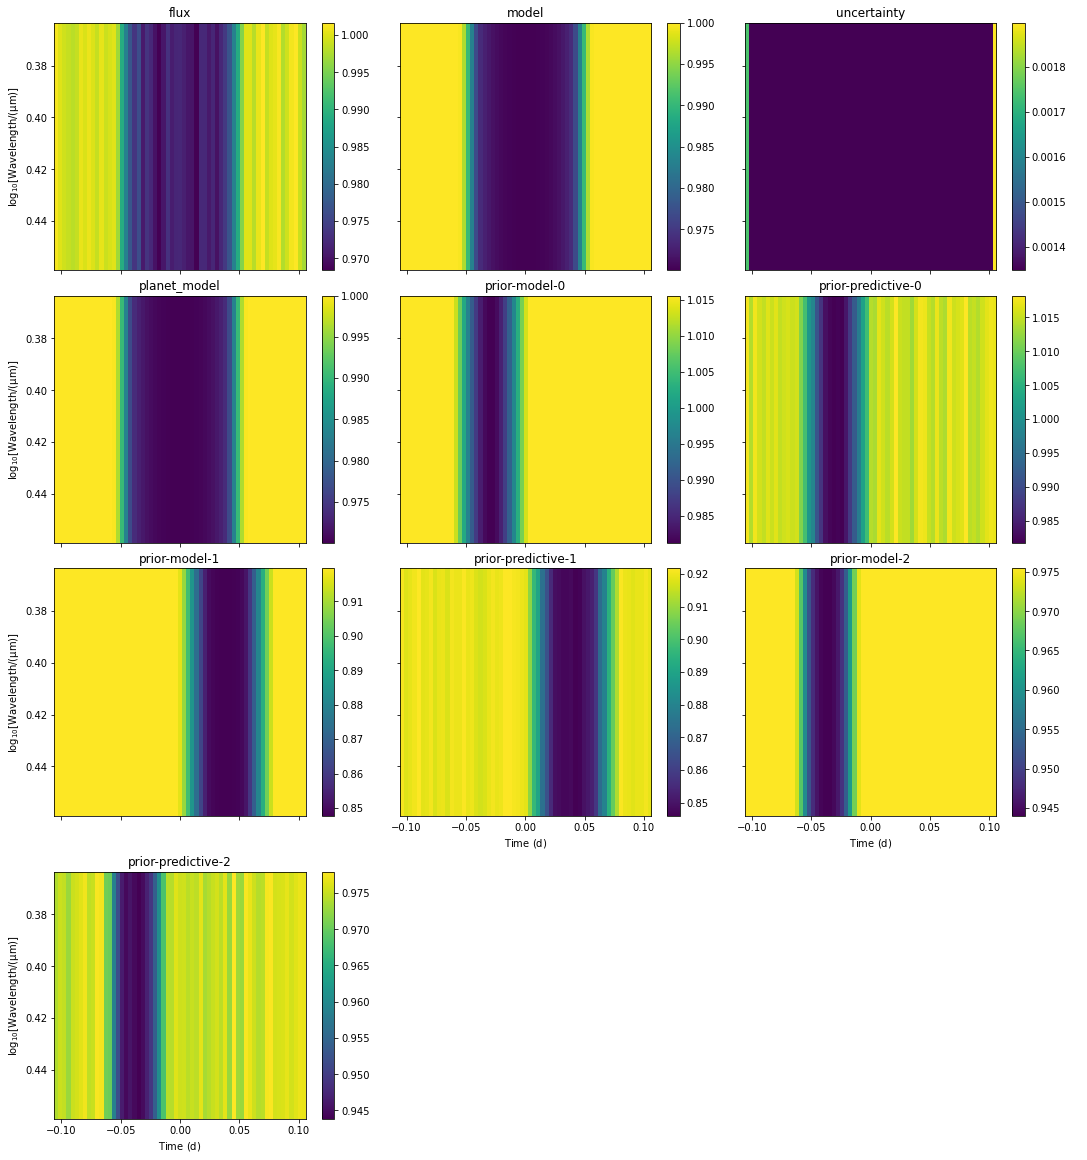

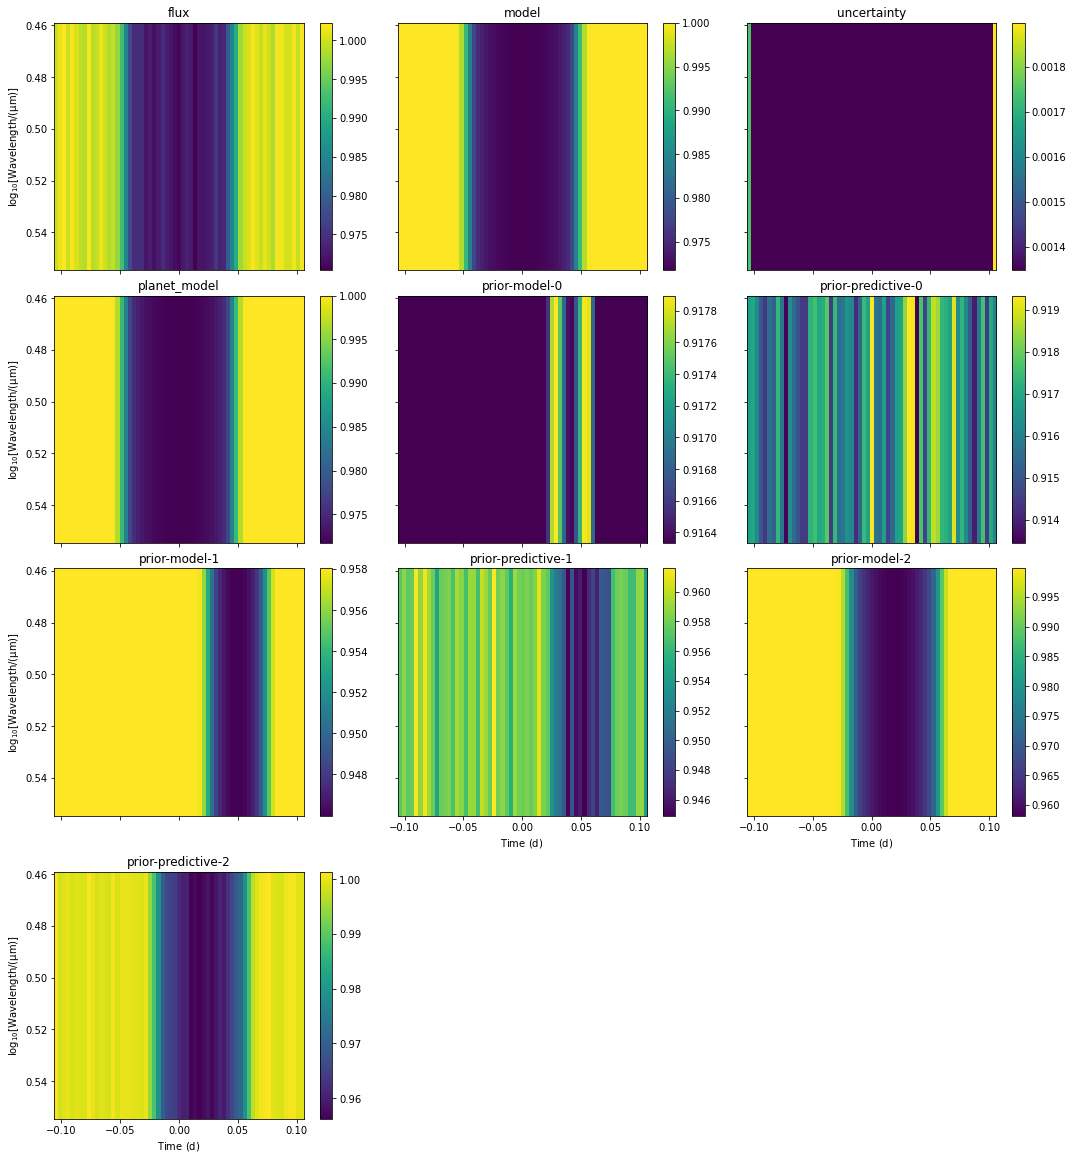

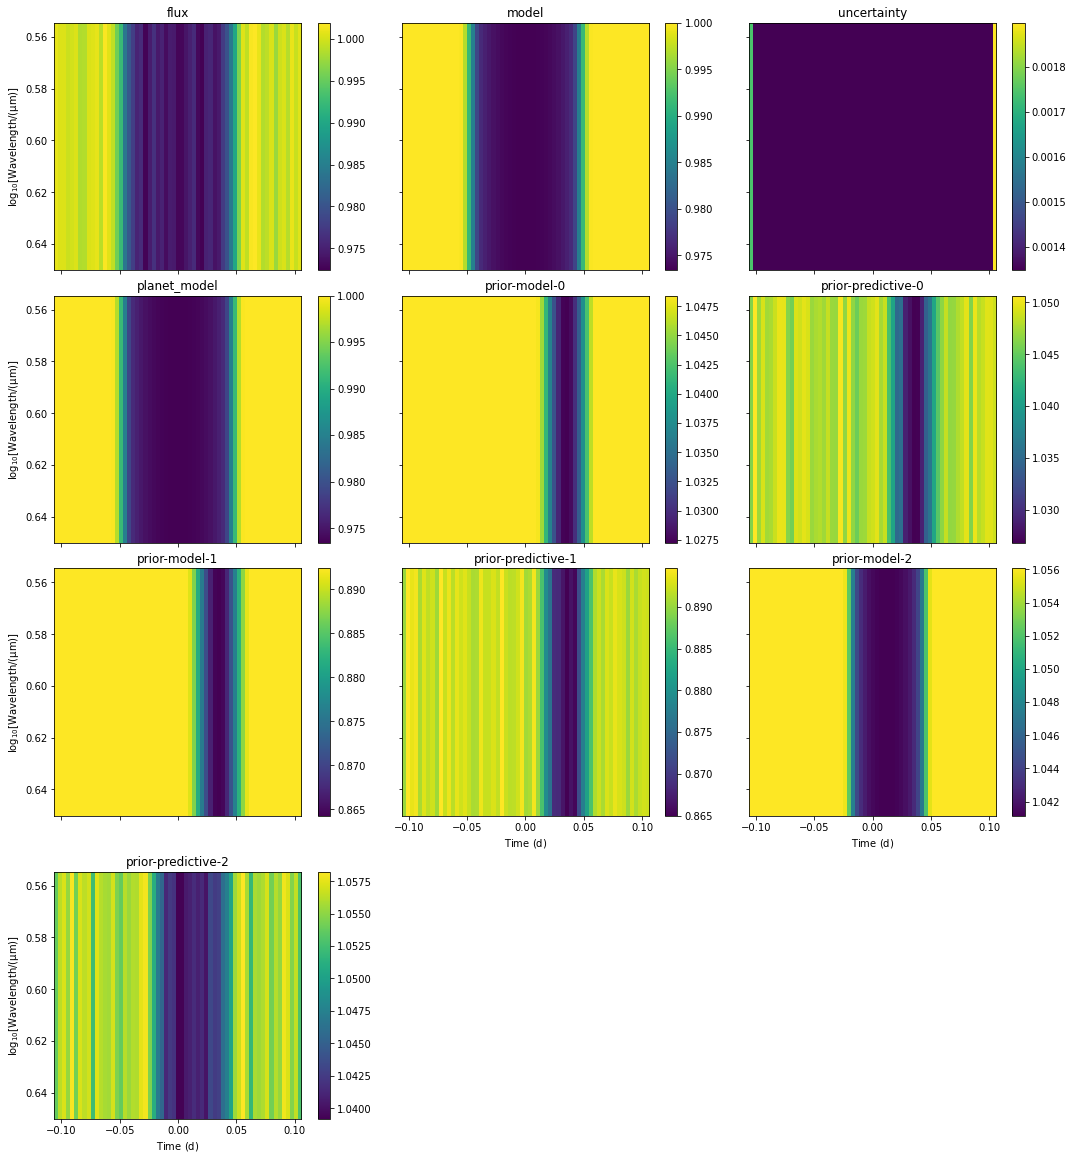

In [14]:
# t.apply_operation_to_constituent_models('plot_priors')()
t.plot_priors()

Plotting the priors can be reassuring for two reasons: (1) we're not giving priors that are vastly off from the true values, and (2) we're not over-constraining our model by giving it the exact solution and priors that are too tight.

Another check is does this planetary system actually transit given our parameters?

In [15]:
t.plot_orbit()

Running this once...


AttributeError: 

Looks good! And a final check of what the actual lightcurves look like:

The summarize step has not been run yet. To include the 'best-fit' model please run {self}.sample() and {self}.summarize() before calling this step!


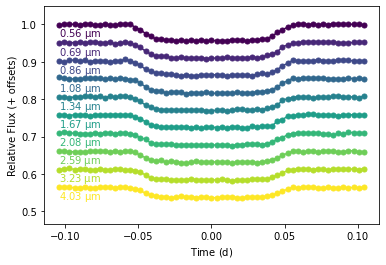

In [16]:
t.plot_lightcurves()

## PyMC3 sampling

Now we can run the NUTS sampling for our light curves (first by optimizing our initial values)

optimize called
(<chromatic models (10 separate wavelengths) "transit" 🌈>,)
{'plot': True}
<class 'chromatic_fitting.models.transit.TransitModel'>


optimizing logp for variables: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


message: Optimization terminated successfully.
logp: -2734.607353713021 -> 317.85324173409333


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:550: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(


<class 'chromatic_fitting.models.transit.TransitModel'>


optimizing logp for variables: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


message: Desired error not necessarily achieved due to precision loss.
logp: -2246.2025567836154 -> 316.2213191736372


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:550: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(


<class 'chromatic_fitting.models.transit.TransitModel'>


optimizing logp for variables: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


message: Optimization terminated successfully.
logp: -1849.242163498954 -> 301.68545350930407


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:550: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(


<class 'chromatic_fitting.models.transit.TransitModel'>


optimizing logp for variables: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


message: Desired error not necessarily achieved due to precision loss.
logp: -1596.1065480457426 -> 308.8781080216656
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:550: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(


<class 'chromatic_fitting.models.transit.TransitModel'>


optimizing logp for variables: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


message: Desired error not necessarily achieved due to precision loss.
logp: -1330.380462780028 -> 311.6591339484194


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:550: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(


<class 'chromatic_fitting.models.transit.TransitModel'>


optimizing logp for variables: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


message: Desired error not necessarily achieved due to precision loss.
logp: -1002.6909254597447 -> -666.0434615437505


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:550: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(


<class 'chromatic_fitting.models.transit.TransitModel'>


optimizing logp for variables: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


message: Desired error not necessarily achieved due to precision loss.
logp: -841.0582566806515 -> 305.24408817329856


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:550: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(


<class 'chromatic_fitting.models.transit.TransitModel'>


optimizing logp for variables: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


message: Desired error not necessarily achieved due to precision loss.
logp: -653.9457397579326 -> 312.66101962644564


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:550: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(


<class 'chromatic_fitting.models.transit.TransitModel'>


optimizing logp for variables: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


message: Desired error not necessarily achieved due to precision loss.
logp: -524.5617654464279 -> 318.8490408470965


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:550: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(


<class 'chromatic_fitting.models.transit.TransitModel'>


optimizing logp for variables: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


message: Desired error not necessarily achieved due to precision loss.
logp: -478.3043954697077 -> 316.5217772099092


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:550: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(


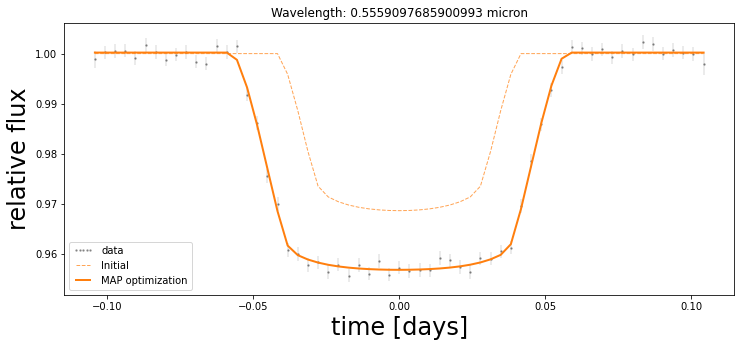

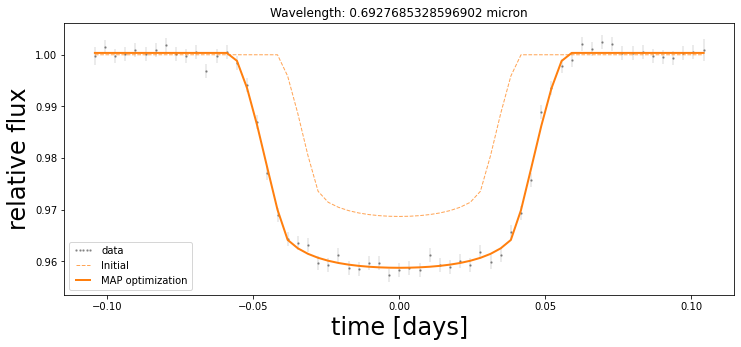

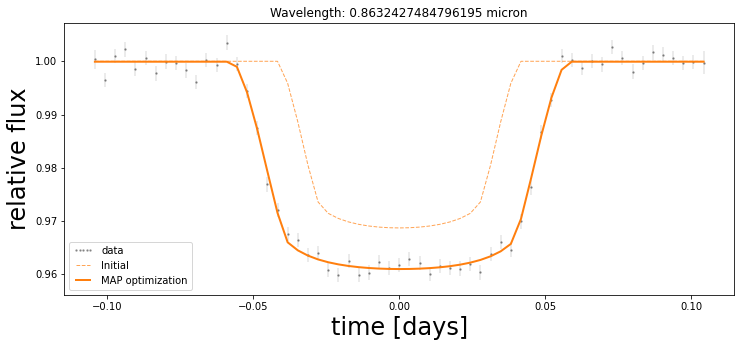

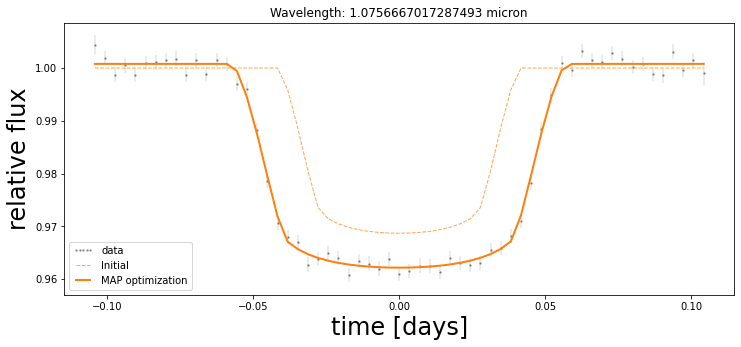

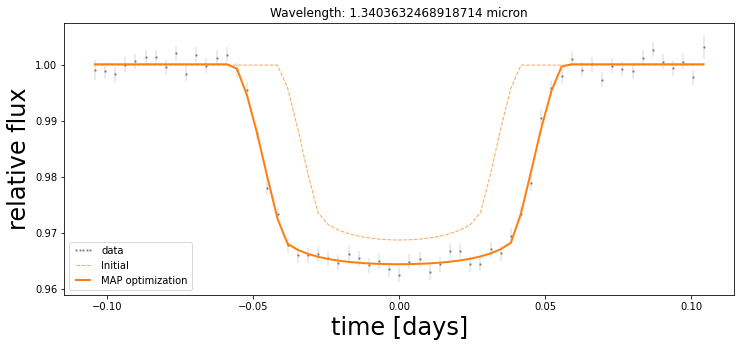

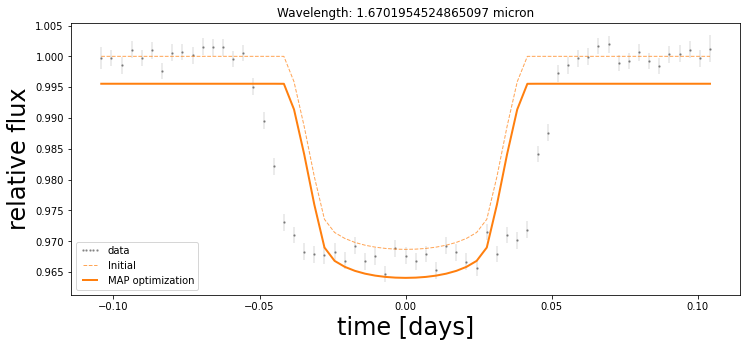

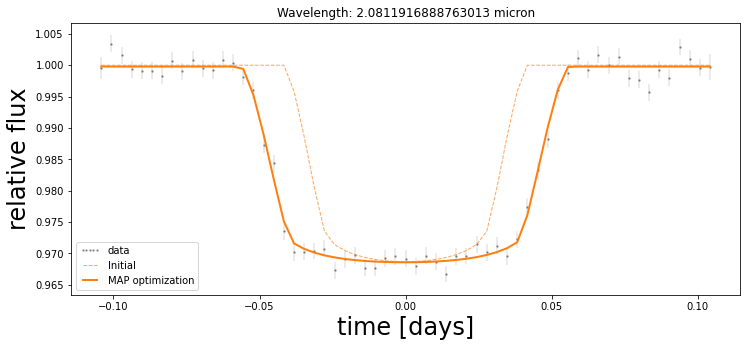

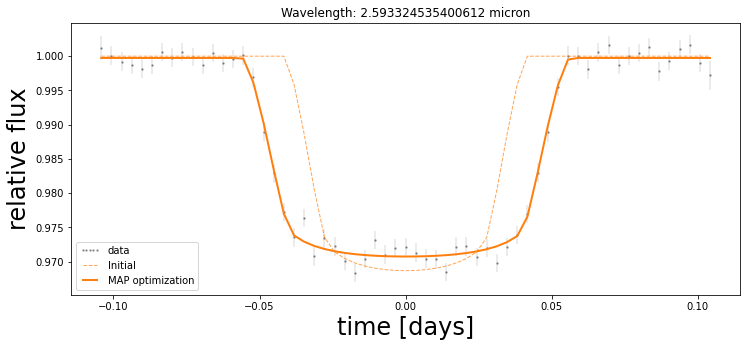

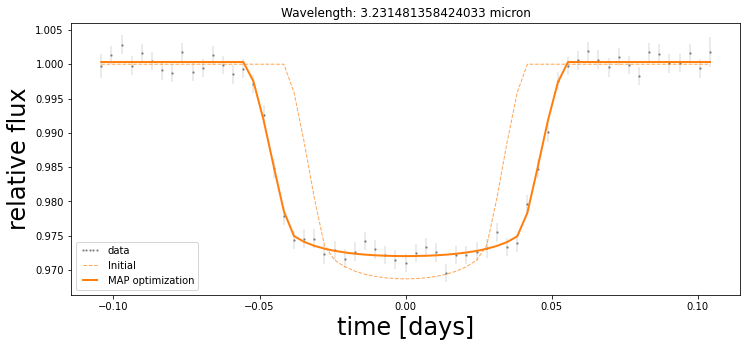

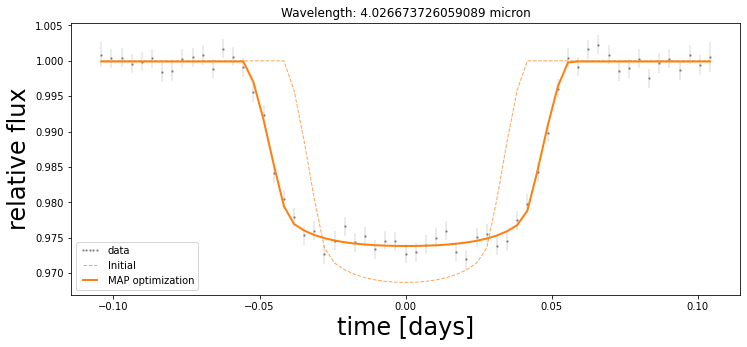

In [17]:
# optimize for initial values!
opt = t.optimize(plot=True)

In [18]:
# put those initial values into the sampling and define the number of tuning and draw steps, 
# as well as the number of chains. NOTE: if you do separate wavelength fitting then the number of steps 
# is per wavelengths, not divided between the wavelengths!
t.sample(use_optimized_start_point=True, tune=2000, draws=2000, chains=4, cores=4) #start=opt, 

sample called
(<chromatic models (10 separate wavelengths) "transit" 🌈>,)
{'use_optimized_start_point': True, 'tune': 2000, 'draws': 2000, 'chains': 4, 'cores': 4}
<class 'chromatic_fitting.models.transit.TransitModel'>
Sampling model using the <function sample at 0x288330280> method
Using MAP-optimized start point...


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 62 seconds.
There were 367 divergences after tuning. Increase `target_accept` or reparameter

                                  mean        sd   hdi_16%   hdi_84%  \
transit_radius_ratio[0]       0.200787  0.001866  0.199058  0.202688   
transit_baseline[0]           1.000211  0.000257  0.999965  1.000477   
transit_epoch[0]             -0.000107  0.000185 -0.000288  0.000074   
transit_impact_parameter[0]   0.142573  0.085938  0.000057  0.188225   
transit_stellar_radius[0]     1.178106  0.015306  1.172467  1.199717   
transit_stellar_mass[0]       0.841266  0.033348  0.800261  0.855479   
transit_limb_darkening[0, 0]  0.099243  0.067186  0.000494  0.130917   
transit_limb_darkening[0, 1]  0.224891  0.144765  0.002577  0.293001   
transit_a_R*[0]               3.371777  0.043296  3.338557  3.426756   
transit_planet_radius[0]      0.236546  0.003666  0.233843  0.241561   

                              mcse_mean   mcse_sd    ess_bulk    ess_tail  \
transit_radius_ratio[0]        0.000177  0.000126  104.161366  101.531833   
transit_baseline[0]            0.000015  0.000011  29

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 54 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameteri

                                  mean        sd   hdi_16%   hdi_84%  \
transit_radius_ratio[0]       0.193589  0.001861  0.191948  0.195553   
transit_baseline[0]           1.000357  0.000253  1.000115  1.000615   
transit_epoch[0]              0.000013  0.000208 -0.000201  0.000210   
transit_impact_parameter[0]   0.085507  0.058520  0.000191  0.108842   
transit_stellar_radius[0]     1.183106  0.011702  1.178319  1.199955   
transit_stellar_mass[0]       0.836270  0.025297  0.800007  0.846091   
transit_limb_darkening[0, 0]  0.153339  0.082378  0.065759  0.247118   
transit_limb_darkening[0, 1]  0.293433  0.181512  0.004243  0.379576   
transit_a_R*[0]               3.350997  0.033418  3.321344  3.388826   
transit_planet_radius[0]      0.229030  0.002682  0.226125  0.231632   

                              mcse_mean   mcse_sd     ess_bulk     ess_tail  \
transit_radius_ratio[0]        0.000055  0.000039  1085.286388  1470.158201   
transit_baseline[0]            0.000005  0.000004

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 53 seconds.
There were 47 divergences after tuning. Increase `target_accept` or reparameteri

                                  mean        sd   hdi_16%   hdi_84%  \
transit_radius_ratio[0]       0.187468  0.001760  0.185905  0.189291   
transit_baseline[0]           0.999920  0.000251  0.999682  1.000174   
transit_epoch[0]              0.000289  0.000223  0.000082  0.000521   
transit_impact_parameter[0]   0.083346  0.057459  0.001141  0.106253   
transit_stellar_radius[0]     1.183482  0.011205  1.178906  1.199901   
transit_stellar_mass[0]       0.835820  0.024360  0.800260  0.845455   
transit_limb_darkening[0, 0]  0.157525  0.083299  0.073927  0.256663   
transit_limb_darkening[0, 1]  0.275967  0.176393  0.000976  0.357774   
transit_a_R*[0]               3.349327  0.030762  3.319702  3.382417   
transit_planet_radius[0]      0.221860  0.002616  0.218755  0.224058   

                              mcse_mean   mcse_sd     ess_bulk     ess_tail  \
transit_radius_ratio[0]        0.000053  0.000038  1050.707332  1114.107186   
transit_baseline[0]            0.000006  0.000004

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 54 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameteri

                                  mean        sd   hdi_16%   hdi_84%  \
transit_radius_ratio[0]       0.186129  0.001762  0.184378  0.187862   
transit_baseline[0]           1.000783  0.000253  1.000540  1.001036   
transit_epoch[0]             -0.000044  0.000222 -0.000262  0.000177   
transit_impact_parameter[0]   0.078112  0.054758  0.000034  0.098962   
transit_stellar_radius[0]     1.184949  0.010760  1.180636  1.199998   
transit_stellar_mass[0]       0.832697  0.022940  0.800013  0.841480   
transit_limb_darkening[0, 0]  0.168809  0.086174  0.080938  0.267946   
transit_limb_darkening[0, 1]  0.281863  0.172566  0.026047  0.375776   
transit_a_R*[0]               3.341047  0.030695  3.310191  3.372772   
transit_planet_radius[0]      0.220549  0.002486  0.217761  0.222831   

                              mcse_mean   mcse_sd     ess_bulk     ess_tail  \
transit_radius_ratio[0]        0.000034  0.000024  2632.397500  2493.189577   
transit_baseline[0]            0.000005  0.000003

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 54 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameteri

                                  mean        sd   hdi_16%   hdi_84%  \
transit_radius_ratio[0]       0.181702  0.001790  0.180147  0.183633   
transit_baseline[0]           1.000157  0.000252  0.999881  1.000375   
transit_epoch[0]             -0.000243  0.000233 -0.000479 -0.000015   
transit_impact_parameter[0]   0.102001  0.067151  0.000199  0.130684   
transit_stellar_radius[0]     1.180083  0.013690  1.174211  1.199974   
transit_stellar_mass[0]       0.845769  0.030206  0.802357  0.860889   
transit_limb_darkening[0, 0]  0.124821  0.074310  0.013289  0.169641   
transit_limb_darkening[0, 1]  0.218182  0.148988  0.001554  0.280907   
transit_a_R*[0]               3.372143  0.036375  3.338390  3.411576   
transit_planet_radius[0]      0.214421  0.003023  0.211427  0.217691   

                              mcse_mean   mcse_sd     ess_bulk     ess_tail  \
transit_radius_ratio[0]        0.000041  0.000029  1831.108285  1705.022447   
transit_baseline[0]            0.000005  0.000003

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 54 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameteri

                                  mean        sd   hdi_16%   hdi_84%  \
transit_radius_ratio[0]       0.175184  0.001670  0.173651  0.176944   
transit_baseline[0]           1.000163  0.000248  0.999934  1.000427   
transit_epoch[0]             -0.000026  0.000239 -0.000259  0.000215   
transit_impact_parameter[0]   0.096023  0.066639  0.000045  0.122780   
transit_stellar_radius[0]     1.179305  0.014196  1.172613  1.199999   
transit_stellar_mass[0]       0.849139  0.031604  0.800083  0.862962   
transit_limb_darkening[0, 0]  0.114963  0.070029  0.020320  0.165929   
transit_limb_darkening[0, 1]  0.198134  0.138864  0.000121  0.257420   
transit_a_R*[0]               3.378785  0.035135  3.346284  3.416672   
transit_planet_radius[0]      0.206592  0.002975  0.203660  0.209960   

                              mcse_mean   mcse_sd     ess_bulk     ess_tail  \
transit_radius_ratio[0]        0.000044  0.000031  1455.190090  1557.968339   
transit_baseline[0]            0.000005  0.000003

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 55 seconds.
There were 104 divergences after tuning. Increase `target_accept` or reparameter

                                  mean        sd   hdi_16%   hdi_84%  \
transit_radius_ratio[0]       0.169736  0.001912  0.167861  0.171632   
transit_baseline[0]           0.999796  0.000246  0.999555  1.000053   
transit_epoch[0]             -0.000281  0.000257 -0.000560 -0.000057   
transit_impact_parameter[0]   0.132908  0.082227  0.004705  0.179944   
transit_stellar_radius[0]     1.182814  0.013109  1.177437  1.199994   
transit_stellar_mass[0]       0.840468  0.029142  0.801435  0.851880   
transit_limb_darkening[0, 0]  0.119740  0.074603  0.001819  0.155025   
transit_limb_darkening[0, 1]  0.220781  0.156093  0.000483  0.287830   
transit_a_R*[0]               3.357397  0.041354  3.315704  3.402671   
transit_planet_radius[0]      0.200765  0.003085  0.197331  0.203561   

                              mcse_mean   mcse_sd     ess_bulk     ess_tail  \
transit_radius_ratio[0]        0.000150  0.000107   161.202140   222.368627   
transit_baseline[0]            0.000006  0.000004

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 54 seconds.
There were 43 divergences after tuning. Increase `target_accept` or reparameteri

                                  mean        sd   hdi_16%   hdi_84%  \
transit_radius_ratio[0]       0.162842  0.001842  0.161119  0.164775   
transit_baseline[0]           0.999752  0.000251  0.999516  1.000009   
transit_epoch[0]              0.000137  0.000273 -0.000131  0.000414   
transit_impact_parameter[0]   0.106083  0.070150  0.000532  0.140339   
transit_stellar_radius[0]     1.184402  0.011833  1.179967  1.199987   
transit_stellar_mass[0]       0.835729  0.026201  0.800002  0.845623   
transit_limb_darkening[0, 0]  0.126217  0.079284  0.010168  0.170351   
transit_limb_darkening[0, 1]  0.263576  0.166767  0.000197  0.341966   
transit_a_R*[0]               3.346602  0.036128  3.315017  3.389371   
transit_planet_radius[0]      0.192866  0.002678  0.190025  0.195548   

                              mcse_mean   mcse_sd     ess_bulk     ess_tail  \
transit_radius_ratio[0]        0.000036  0.000025  2595.422906  2620.978928   
transit_baseline[0]            0.000005  0.000003

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 56 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameteri

                                  mean        sd   hdi_16%   hdi_84%  \
transit_radius_ratio[0]       0.161457  0.001850  0.159759  0.163411   
transit_baseline[0]           1.000336  0.000255  1.000068  1.000567   
transit_epoch[0]              0.000061  0.000284 -0.000197  0.000366   
transit_impact_parameter[0]   0.120285  0.075542  0.000003  0.157426   
transit_stellar_radius[0]     1.177663  0.015517  1.171359  1.199955   
transit_stellar_mass[0]       0.847995  0.033947  0.800855  0.861633   
transit_limb_darkening[0, 0]  0.134209  0.080274  0.029700  0.198461   
transit_limb_darkening[0, 1]  0.213148  0.160383  0.000006  0.281188   
transit_a_R*[0]               3.381979  0.041358  3.346540  3.430963   
transit_planet_radius[0]      0.190137  0.003042  0.187263  0.193532   

                              mcse_mean   mcse_sd     ess_bulk     ess_tail  \
transit_radius_ratio[0]        0.000039  0.000027  2239.033619  2533.449469   
transit_baseline[0]            0.000005  0.000003

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 52 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameteri

                                  mean        sd   hdi_16%   hdi_84%  \
transit_radius_ratio[0]       0.153319  0.001983  0.151484  0.155488   
transit_baseline[0]           0.999923  0.000243  0.999679  1.000156   
transit_epoch[0]              0.000233  0.000312 -0.000079  0.000530   
transit_impact_parameter[0]   0.106716  0.071212  0.001125  0.140028   
transit_stellar_radius[0]     1.186852  0.010419  1.183850  1.199967   
transit_stellar_mass[0]       0.829249  0.023417  0.800068  0.836416   
transit_limb_darkening[0, 0]  0.131476  0.086664  0.000353  0.170208   
transit_limb_darkening[0, 1]  0.328740  0.188258  0.091228  0.495914   
transit_a_R*[0]               3.331102  0.035537  3.287196  3.360406   
transit_planet_radius[0]      0.181963  0.002598  0.179094  0.184316   

                              mcse_mean   mcse_sd     ess_bulk     ess_tail  \
transit_radius_ratio[0]        0.000045  0.000032  1877.676191  1508.630629   
transit_baseline[0]            0.000005  0.000003

At this stage the sampler may print out some warnings that we don't have enough tuning steps! Also be aware this step can be quite slow depending on how many parameters we're trying to fit at once (which may increase with the number of wavelengths). We can then see the results of our sampling by running `.summarize()`:

In [19]:
t.summary

,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
transit_radius_ratio[0],0.200787,0.001866,0.199058,0.202688,0.000177,0.000126,104.161366,101.531833,1.037506
transit_baseline[0],1.000211,0.000257,0.999965,1.000477,0.000015,0.000011,291.146182,548.462556,1.012666
transit_epoch[0],-0.000107,0.000185,-0.000288,0.000074,0.000007,0.000005,615.686124,794.389641,1.008745
transit_impact_parameter[0],0.142573,0.085938,0.000057,0.188225,0.010500,0.008866,66.436191,68.299792,1.056587
transit_stellar_radius[0],1.178106,0.015306,1.172467,1.199717,0.001147,0.000812,183.409944,124.366502,1.039449
...,...,...,...,...,...,...,...,...,...
transit_stellar_mass[9],0.829249,0.023417,0.800068,0.836416,0.000511,0.000362,1290.054494,1152.998960,1.002249
"transit_limb_darkening[9, 9]",0.131476,0.086664,0.000353,0.170208,0.002287,0.001618,1192.205289,1204.366147,1.002499
"transit_limb_darkening[9, 1]",0.328740,0.188258,0.091228,0.495914,0.005128,0.003627,988.344752,584.389355,1.003101
transit_a_R*[9],3.331102,0.035537,3.287196,3.360406,0.000797,0.000563,1743.785676,987.528281,1.000577


An important parameter to look out for here to check whether your samplings have converged is [`r_hat`](https://arviz-devs.github.io/arviz/api/generated/arviz.rhat.html#arviz.rhat). This [rank normalized R-hat diagnostic](https://arxiv.org/abs/1903.08008) tests for lack of convergence by comparing the variance between multiple chains to the variance within each chain. If convergence has been achieved, the between-chain and within-chain variances should be identicalm therefore, the closer it is to 1 the better the chance that your sampling successfully converged. If you're interested in the sampling see the [`PyMC3 docs`](https://docs.pymc.io/en/v3/index.html) for much more detail!

In [21]:
np.all(t.summary['r_hat'].values < 1.1) # check the convergence is good!

False

We might also want to see a couple of posterior samples as a "quick-look" check! **But beware** if you've chosen the "separate" optimization method then it will plot the posteriors for every wavelength!):

In [ ]:
# t.plot_posteriors()

But what are the results?? We can easily see the results using the handy `.get_results()` function:

In [22]:
t.parameters['transit_a_R*'] = []
results = t.get_results(uncertainty='sd')#['hdi_16%','hdi_84%'])

# results is a pandas dataframe, however, it doesn't show up properly on Git docs so I'll convert it to an
# astropy table
from astropy.table import Table
Table.from_pandas(results)

transit_baseline,transit_baseline_hdi_16%,transit_baseline_hdi_84%,transit_eccentricity,transit_eccentricity_hdi_16%,transit_eccentricity_hdi_84%,transit_epoch,transit_epoch_hdi_16%,transit_epoch_hdi_84%,transit_impact_parameter,transit_impact_parameter_hdi_16%,transit_impact_parameter_hdi_84%,transit_limb_darkening,transit_limb_darkening_hdi_16%,transit_limb_darkening_hdi_84%,transit_omega,transit_omega_hdi_16%,transit_omega_hdi_84%,transit_period,transit_period_hdi_16%,transit_period_hdi_84%,transit_radius_ratio,transit_radius_ratio_hdi_16%,transit_radius_ratio_hdi_84%,transit_stellar_mass,transit_stellar_mass_hdi_16%,transit_stellar_mass_hdi_84%,transit_stellar_radius,transit_stellar_radius_hdi_16%,transit_stellar_radius_hdi_84%,wavelength
object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
1.0002114,0.9999647,1.0004775,0.0,0.0,0.0,-0.000107,-0.0002884,7.43e-05,0.1425732,5.69e-05,0.188225,"[0.0992433, 0.224891]","[0.0004941, 0.0025768]","[0.1309175, 0.2930013]",0,0,0,1.0,1.0,1.0,0.2007865,0.1990577,0.2026883,0.841266,0.8002615,0.8554795,1.1781064,1.172467,1.1997168,0.5559097685900993 micron
1.0003571,1.0001147,1.000615,0.0,0.0,0.0,1.33e-05,-0.0002013,0.0002096,0.0855073,0.0001913,0.1088418,"[0.1533389, 0.2934333]","[0.0657594, 0.004243]","[0.2471177, 0.3795765]",0,0,0,1.0,1.0,1.0,0.1935888,0.1919476,0.1955535,0.8362703,0.8000075,0.8460911,1.1831058,1.1783186,1.1999547,0.6927685328596902 micron
0.9999204,0.9996816,1.0001737,0.0,0.0,0.0,0.0002885,8.18e-05,0.0005212,0.0833461,0.0011413,0.1062531,"[0.1575254, 0.2759675]","[0.0739271, 0.0009761]","[0.2566625, 0.3577735]",0,0,0,1.0,1.0,1.0,0.1874676,0.1859051,0.1892909,0.8358204,0.8002596,0.845455,1.1834823,1.1789063,1.1999008,0.8632427484796195 micron
1.0007832,1.0005403,1.0010358,0.0,0.0,0.0,-4.38e-05,-0.0002623,0.0001774,0.0781115,3.36e-05,0.0989623,"[0.1688088, 0.2818629]","[0.0809378, 0.0260469]","[0.2679459, 0.3757761]",0,0,0,1.0,1.0,1.0,0.1861294,0.1843778,0.1878622,0.8326966,0.800013,0.8414796,1.1849488,1.1806357,1.1999978,1.0756667017287493 micron
1.0001568,0.9998811,1.0003752,0.0,0.0,0.0,-0.000243,-0.0004786,-1.47e-05,0.1020009,0.0001987,0.130684,"[0.1248208, 0.2181822]","[0.0132887, 0.0015538]","[0.1696414, 0.2809069]",0,0,0,1.0,1.0,1.0,0.1817025,0.1801469,0.1836333,0.8457693,0.8023569,0.8608887,1.1800832,1.1742106,1.1999743,1.3403632468918714 micron
1.0001626,0.9999338,1.0004273,0.0,0.0,0.0,-2.56e-05,-0.0002591,0.0002147,0.096023,4.5e-05,0.1227801,"[0.1149633, 0.1981336]","[0.0203203, 0.0001212]","[0.1659291, 0.2574198]",0,0,0,1.0,1.0,1.0,0.1751837,0.1736515,0.1769436,0.8491393,0.8000832,0.8629616,1.1793052,1.1726134,1.1999986,1.6701954524865097 micron
0.9997962,0.9995548,1.0000531,0.0,0.0,0.0,-0.0002807,-0.0005596,-5.74e-05,0.1329079,0.0047054,0.1799436,"[0.1197403, 0.2207812]","[0.0018186, 0.0004827]","[0.1550247, 0.2878298]",0,0,0,1.0,1.0,1.0,0.1697362,0.1678607,0.1716318,0.8404678,0.801435,0.8518802,1.1828139,1.1774366,1.1999943,2.0811916888763013 micron
0.999752,0.9995161,1.0000087,0.0,0.0,0.0,0.0001367,-0.0001313,0.0004145,0.106083,0.000532,0.1403391,"[0.1262169, 0.2635755]","[0.010168, 0.000197]","[0.1703515, 0.3419662]",0,0,0,1.0,1.0,1.0,0.1628415,0.1611188,0.1647751,0.8357289,0.8000019,0.8456228,1.1844021,1.1799672,1.1999867,2.593324535400612 micron
1.0003355,1.000068,1.0005673,0.0,0.0,0.0,6.13e-05,-0.0001971,0.0003657,0.120285,2.6e-06,0.1574263,"[0.1342092, 0.2131482]","[0.0297004, 6.3e-06]","[0.1984605, 0.2811882]",0,0,0,1.0,1.0,1.0,0.1614573,0.159759,0.1634112,0.8479947,0.8008545,0.8616328,1.1776629,1.171359,1.1999555,3.231481358424033 micron


We can also make a transmission spectrum table using `.make_transmission_spectrum_table() `

In [26]:
transmission_spectrum = t.make_transmission_spectrum_table(uncertainty=['hdi_16%','hdi_84%'])

Table.from_pandas(transmission_spectrum)

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/transit.py:378: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_table[f"{self.name}_radius_ratio_neg_error"] = (


wavelength,transit_radius_ratio,transit_radius_ratio_neg_error,transit_radius_ratio_pos_error
object,object,object,object
0.5559097685900993 micron,0.2007865,0.0017288000000000026,0.0019017999999999813
0.6927685328596902 micron,0.1935888,0.0016412000000000093,0.001964699999999986
0.8632427484796195 micron,0.1874676,0.0015625000000000222,0.0018233
1.0756667017287493 micron,0.1861294,0.001751599999999992,0.0017328000000000066
1.3403632468918714 micron,0.1817025,0.0015555999999999903,0.0019308000000000103
1.6701954524865097 micron,0.1751837,0.0015322000000000113,0.0017599000000000087
2.0811916888763013 micron,0.1697362,0.0018755000000000022,0.0018955999999999973
2.593324535400612 micron,0.1628415,0.0017226999999999937,0.0019336000000000075
3.231481358424033 micron,0.1614573,0.001698299999999986,0.0019539000000000084


We can also create (or call if you set `store_models=True`) the final best-fit models using the `.get_models()` function. This can take a minute if generating the models from parameters for lots of wavelengths.

In [27]:
models = t.get_model()
models.keys()

get_model called
(<chromatic models (10 separate wavelengths) "transit" 🌈>,)
{}
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fittin

dict_keys(['w0', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9'])

As the `.get_model()` process can take time to generate the models, we store the models for use later...

In [33]:
t._fit_models.keys()

dict_keys(['w0', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9'])

## Visualizing Results

We have several different methods (mostly wrappers to `chromatic` functions) to plot the modelled results. I'll demonstrate several of them below:

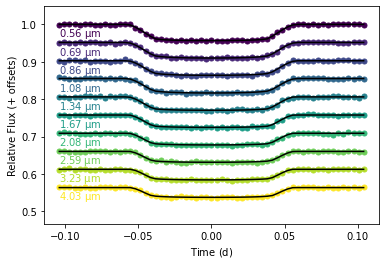

In [29]:
t.plot_lightcurves()

## Check Residuals

No model attached to data. Running `add_model_to_rainbow` now. You can access this data later using [self].data_with_model
add_model_to_rainbow called
(<chromatic models (10 separate wavelengths) "transit" 🌈>,)
{}
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<class 'chromatic_fitting.models.transit.TransitModel'>
<c

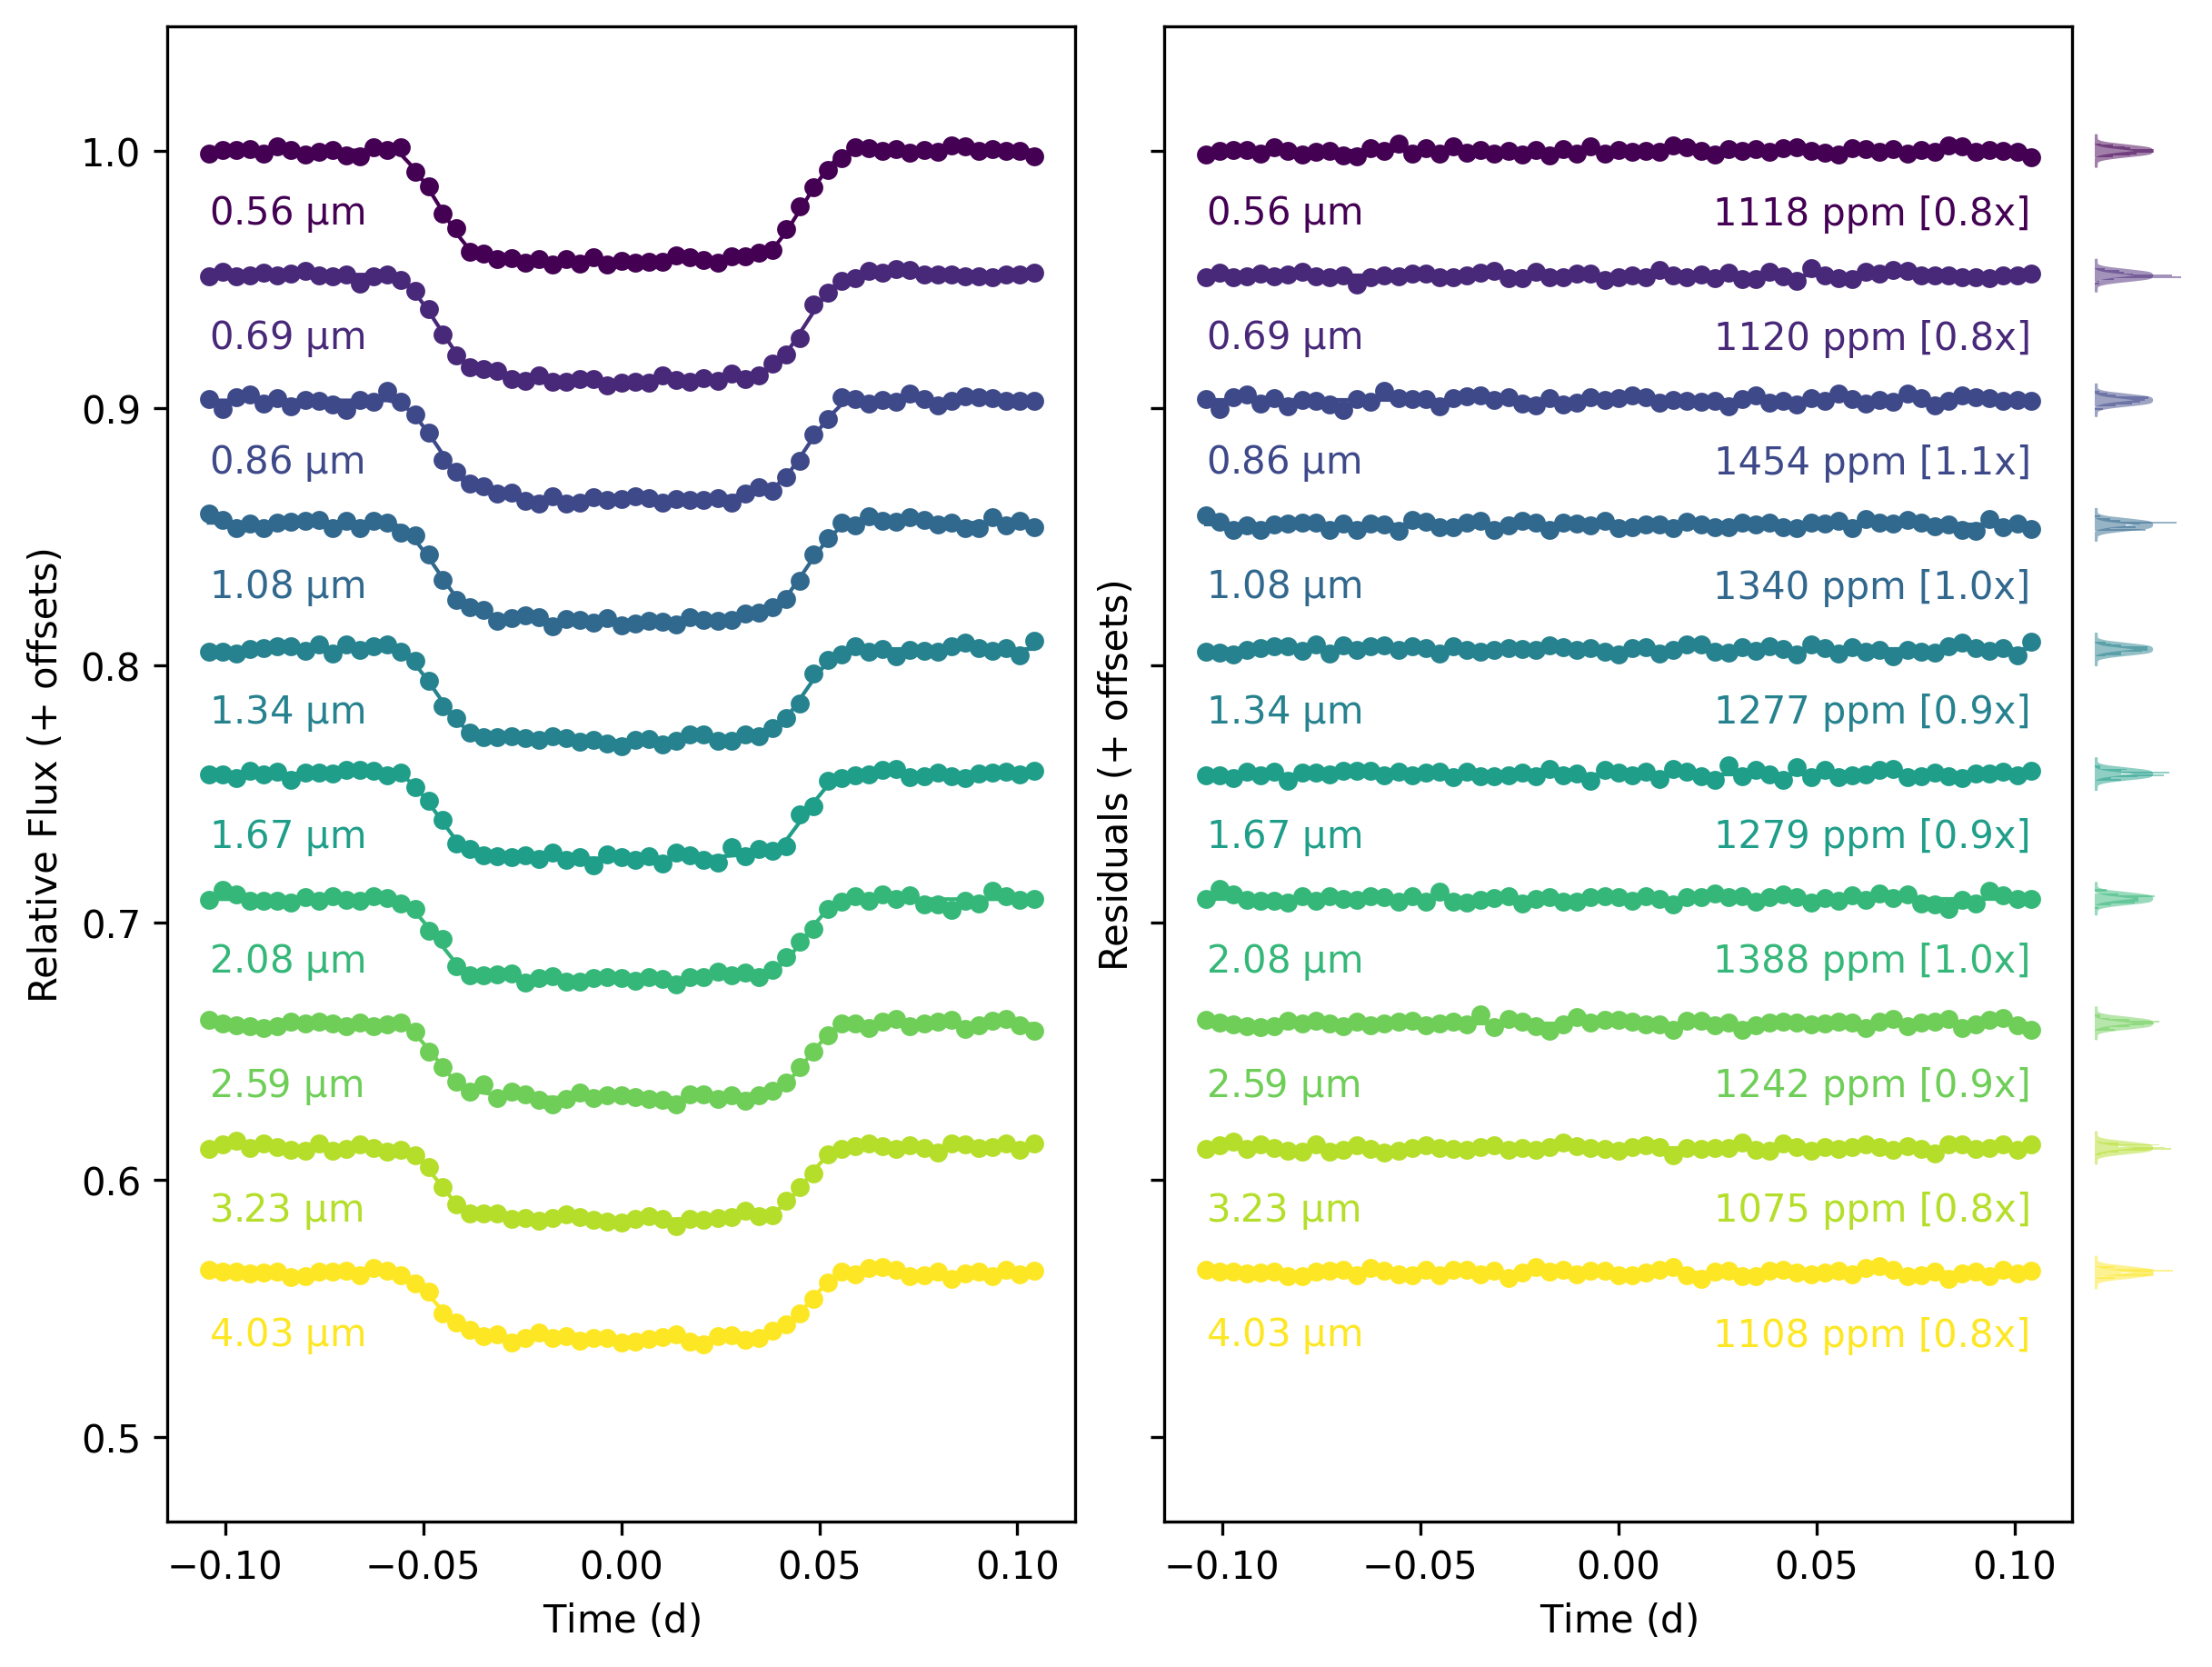

In [30]:
t.plot_with_model_and_residuals()

🌈🤖 'systematics_model' doesn't exist and will be skipped.



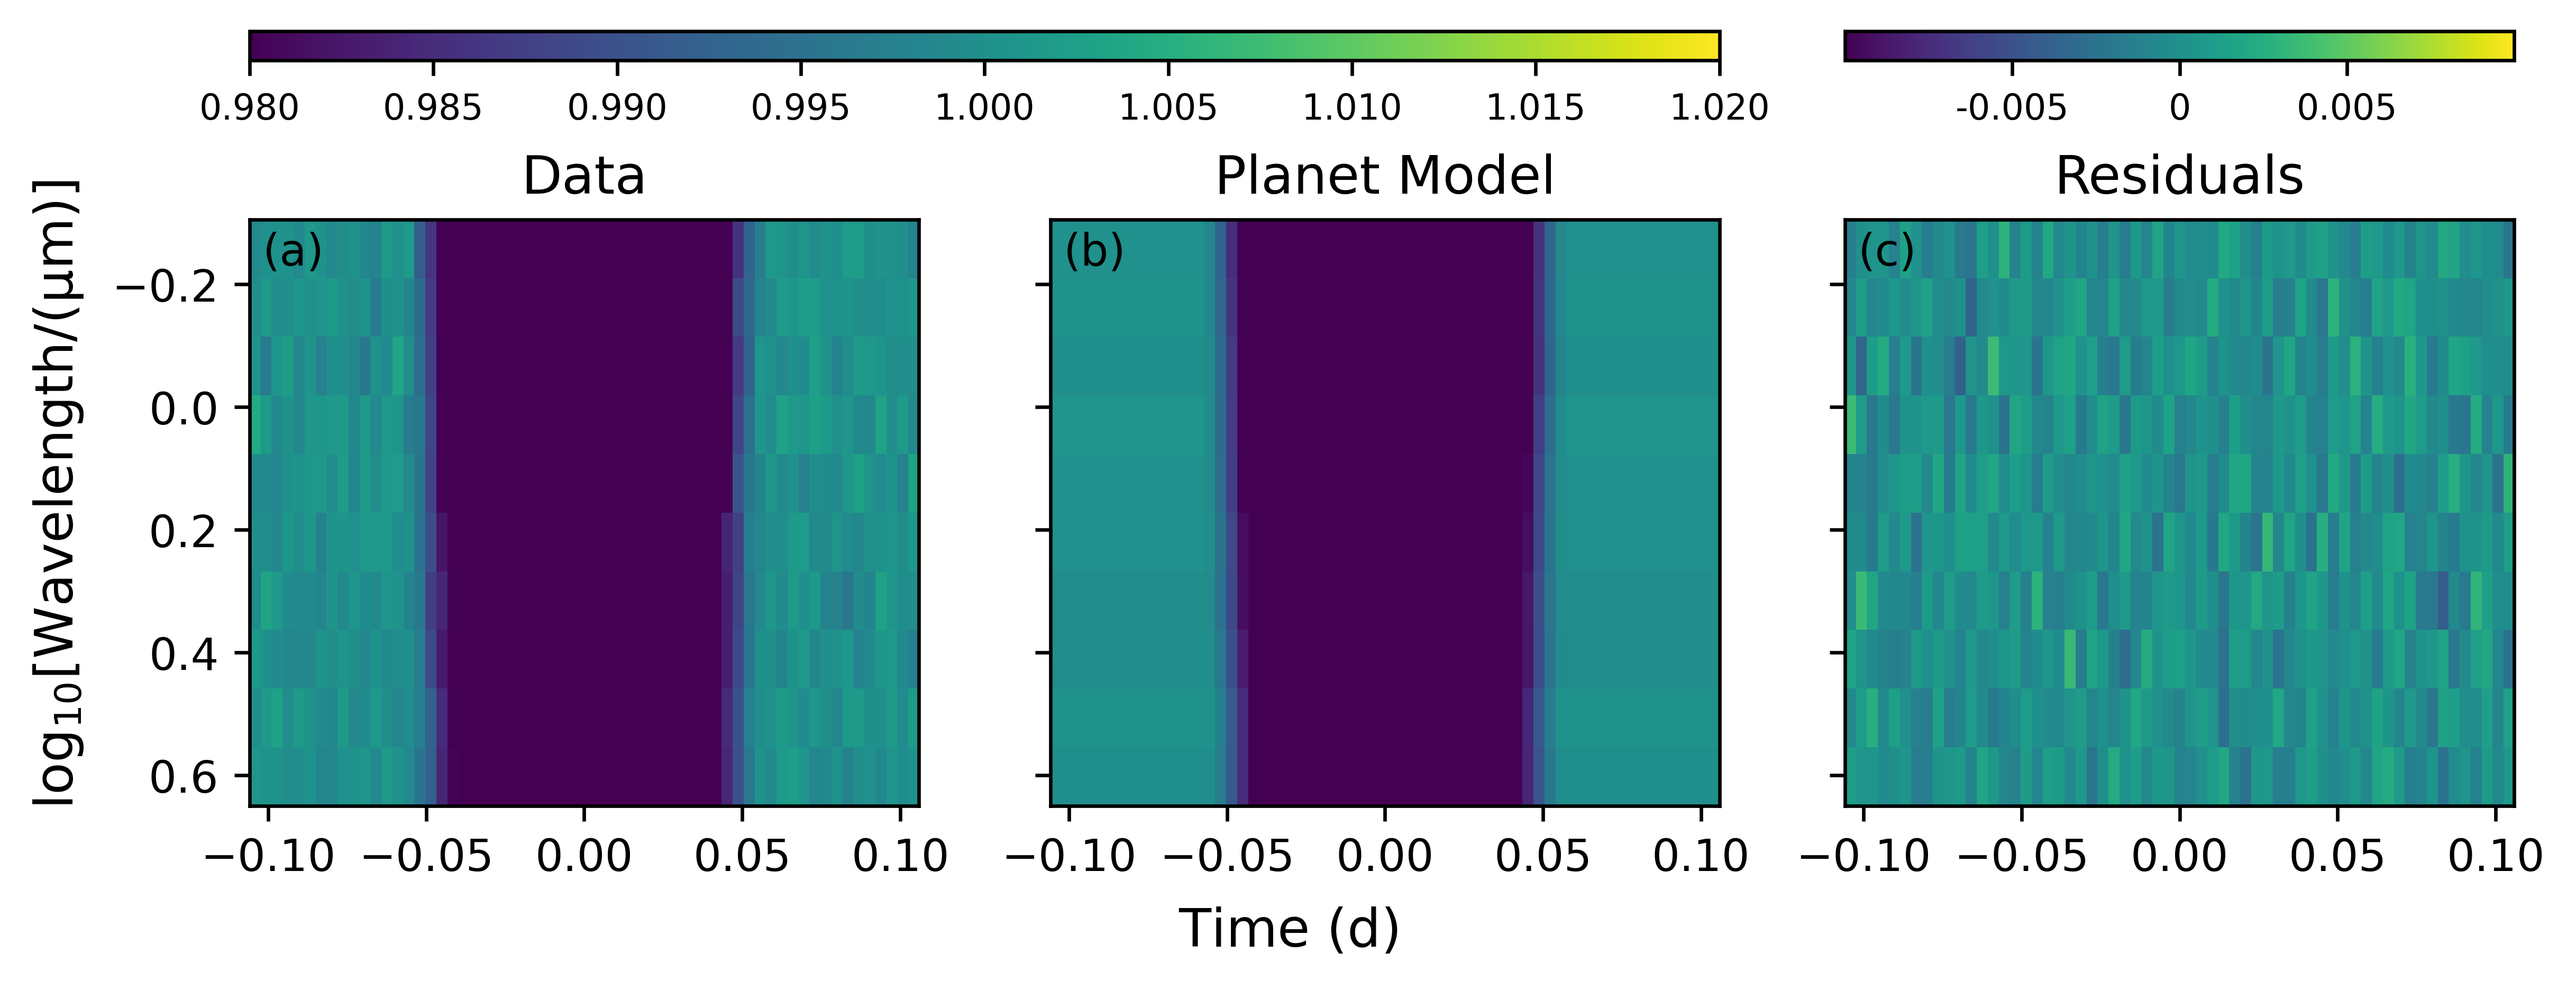

In [31]:
t.imshow_with_models(vspan_residuals=0.01)

## Plot the Transmission Spectrum

We can also plot the transmission spectrum (and we know what the true values are). Here's what we know about the injected transit:

In [34]:
rb.metadata['injected_transit_parameters']

{'rp': array([0.2       , 0.19956522, 0.19913043, 0.19869565, 0.19826087,
        0.19782609, 0.1973913 , 0.19695652, 0.19652174, 0.19608696,
        0.19565217, 0.19521739, 0.19478261, 0.19434783, 0.19391304,
        0.19347826, 0.19304348, 0.1926087 , 0.19217391, 0.19173913,
        0.19130435, 0.19086957, 0.19043478, 0.19      , 0.18956522,
        0.18913043, 0.18869565, 0.18826087, 0.18782609, 0.1873913 ,
        0.18695652, 0.18652174, 0.18608696, 0.18565217, 0.18521739,
        0.18478261, 0.18434783, 0.18391304, 0.18347826, 0.18304348,
        0.1826087 , 0.18217391, 0.18173913, 0.18130435, 0.18086957,
        0.18043478, 0.18      , 0.17956522, 0.17913043, 0.17869565,
        0.17826087, 0.17782609, 0.1773913 , 0.17695652, 0.17652174,
        0.17608696, 0.17565217, 0.17521739, 0.17478261, 0.17434783,
        0.17391304, 0.17347826, 0.17304348, 0.1726087 , 0.17217391,
        0.17173913, 0.17130435, 0.17086957, 0.17043478, 0.17      ,
        0.16956522, 0.16913043, 0.16869565

Plot the transmission spectrum (and in this case we can compare to the original model):

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/transit.py:378: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_table[f"{self.name}_radius_ratio_neg_error"] = (


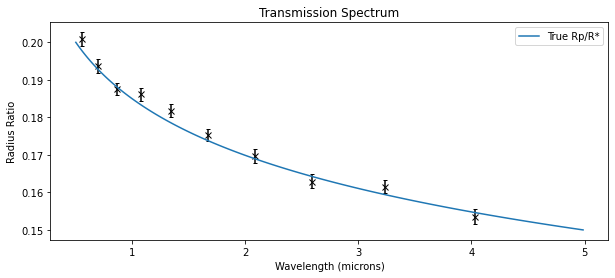

In [35]:
t.plot_transmission_spectrum(uncertainty=['hdi_16%','hdi_84%'])
plt.plot(r.wavelength, rb.metadata['injected_transit_parameters']['rp'], label="True Rp/R*")

plt.legend();

We can also run some diagnostic checks to see the quality of our fit! You might want to check the chi-squared or reduced chi-squared statistic:


For Entire Simultaneous Fit:
Fitted Parameters:
 transit_radius_ratio[0], transit_baseline[0], transit_epoch[0], transit_impact_parameter[0], transit_stellar_radius[0], transit_stellar_mass[0], transit_limb_darkening[0, 0], transit_limb_darkening[0, 1], transit_a_R*[0], transit_planet_radius[0], transit_radius_ratio[1], transit_baseline[1], transit_epoch[1], transit_impact_parameter[1], transit_stellar_radius[1], transit_stellar_mass[1], transit_limb_darkening[1, 1], transit_limb_darkening[1, 1], transit_a_R*[1], transit_planet_radius[1], transit_radius_ratio[2], transit_baseline[2], transit_epoch[2], transit_impact_parameter[2], transit_stellar_radius[2], transit_stellar_mass[2], transit_limb_darkening[2, 2], transit_limb_darkening[2, 1], transit_a_R*[2], transit_planet_radius[2], transit_radius_ratio[3], transit_baseline[3], transit_epoch[3], transit_impact_parameter[3], transit_stellar_radius[3], transit_stellar_mass[3], transit_limb_darkening[3, 3], transit_limb_darkening[3, 1], t

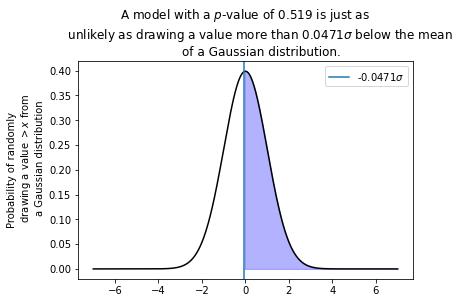

In [36]:
t.chi_squared(plot=True)

Or we can inspect the residual with several different plotting methods:

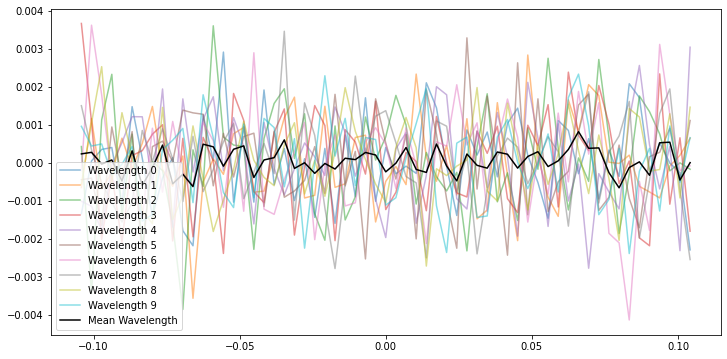

In [37]:
t.plot_residuals()

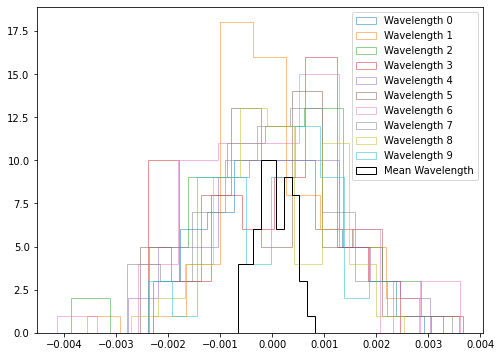

In [38]:
t.plot_residuals_histogram()

For the Wavelength-Averaged Residuals...


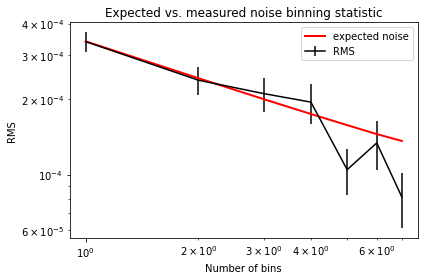

Calculated white noise: 0.00033642 

        Calculated red noise: 4.3963e-05 

        Calculated beta: 1.0962


In [39]:
t.residual_noise_calculator()

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/diagnostics/statistics.py:71: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogx(1 / freq, power)


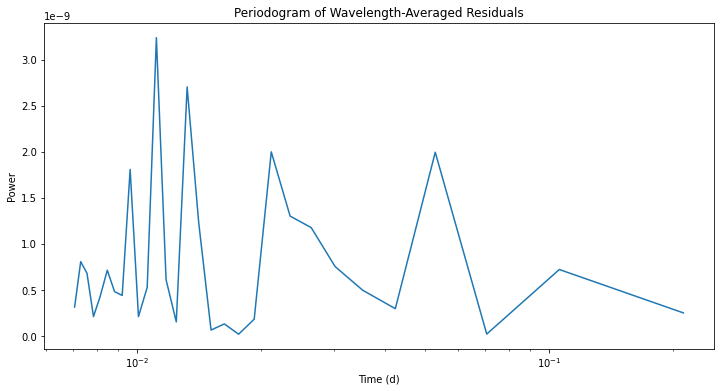

In [40]:
t.plot_residuals_periodogram()